### Initialize

In [1]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd
from pycbc.filter import sigma
import h5py
from pycbc.psd import interpolate, inverse_spectrum_truncation

%matplotlib inline

def gen_template_bank(m_1, m_2, m_radius, temp_numb):

    # Generate templates for BNS
    temp_bank = np.zeros((temp_numb, 2))

    for i in range(temp_numb):
        r1 = np.random.uniform(0, m_radius)
        r2 = np.random.uniform(0, (np.pi*2))
        m1 = r1*(np.cos(r2)) + m_1
        m2 = r1*(np.sin(r2)) + m_2

        temp_bank[i, :] = [m1, m2]

    temp_bank[i,:] = [m_1, m_2]

    return temp_bank

def MF_bank(ts, bank, psd1):
    # this function performs matched filter on a time series with a bank of templates and returns the list of SNR time series

    for i, _ in enumerate(bank):
        print(f'Computing SNR for template {i+1}/{len(bank)}')
        # compute the SNR time series
        bank[i]['snr'], bank[i]['tpeak'], _, _, bank[i]['csnr_peak'] = gen_SNR(bank[i]['template'], ts, psd1)

    return bank

def best_trig(result):
    """
    Find the best trigger in a list of triggers.
    """
    maxSNR = 0
    for i, t in enumerate(result):
        if abs(t['csnr_peak']) > maxSNR:
            maxSNR = abs(t['csnr_peak'])
            maxIndex = i

    return maxIndex

def gen_noise(duration=64):

    # The color of the noise matches a PSD which you provide
    flow = 30.0
    delta_f = 1.0 / 16
    flen = int(2048 / delta_f) + 1
    psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

    # Generate 256 seconds of noise at 4096 Hz
    delta_t = 1.0 / 4096
    tsamples = int(duration/ delta_t)
    ts = pycbc.noise.gaussian.noise_from_psd(tsamples, delta_t, psd, seed=127)

    return ts, psd

def preprocess_bank(bank, N, psd1=None, flow=30):

    new_bank = []
    for t in bank:
        print(t)
        h1 = gen_waveform('IMRPhenomPv2', t[0], t[1], 0, 0, 50, 0)

        h1.resize(N)
        h1 = h1.cyclic_time_shift(h1.sample_times[-1])
        sig1 = sigma(h1, psd=psd1, low_frequency_cutoff=flow)
        h1.data /= sig1
        self_inner, _, _, _, _ = gen_SNR(h1, h1, psd1)

        new_bank.append({'m1': t[0], 'm2': t[1], 'template': h1, 'inner': self_inner})

    return new_bank

def find_peak(snr, mask_between=None):

    if mask_between is not None:
        mask = (snr.sample_times >= mask_between[0]) & (snr.sample_times < mask_between[1])
        snr1 = snr.copy()
        snr1.data[mask] = 0
    else:
        snr1 = snr

    peak = abs(snr1).numpy().argmax()
    snrp = abs(snr1[peak])
    csnrp = snr1[peak]
    tpeak = snr1.sample_times[peak]

    return tpeak, peak, snrp, csnrp

def gen_SNR(template, data, psd):

    snr = matched_filter(template, data,
                         psd=psd, low_frequency_cutoff=30)

    tpeak, peak, snrp, csnrp = find_peak(snr)

    return snr, tpeak, peak, snrp, csnrp

def gen_waveform(model, m1, m2, s1z, s2z, distance, time):

    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    d = Detector("H1")

    fp, fc = d.antenna_pattern(ra, dec, pol, time)
    hp_1, hc_1 = get_td_waveform(approximant=model,
                             mass1=m1, mass2=m2, spin1z=s1z, spin2z=s2z,
                             distance=distance, inclination=inclination_1,
                             delta_t=1.0/4096, f_lower=30)

    ht_1 = fp * hp_1 + fc * hc_1

    return ht_1

def overlap(ht_1,ht_2,buffer):

    if len(ht_1) < len(ht_2):
        ht_small, ht_big = ht_1, ht_2
    else:
        ht_small, ht_big = ht_2, ht_1

    dt = ht_small.delta_t

    # make buffer int multiple of dt
    buffer = np.round(buffer*ht_big.sample_rate)/ht_big.sample_rate
    # elongate the long template to accomodate enough space on left
    ht_big.resize(len(ht_big)+int(buffer*ht_big.sample_rate))
    # match small template
    ht_small.resize(len(ht_big))
    # correct the position after resizing
    ht_big = ht_big.cyclic_time_shift(buffer)
    #Shifting the merger time
    ht_small = ht_small.cyclic_time_shift(ht_small.start_time-ht_big.start_time-buffer)
    #Equating the start time of both signals
    ht_small.start_time = ht_big.start_time
    # resample to original sample rate
    ht_big = ht_big.resample(dt)
    ht_small = ht_small.resample(dt)

    #Combining the signals
    ht_total = ht_small + ht_big

    return ht_total, ht_2

def inject(ht_total,ts,injtime):

    # append extra zeros than required
    ht_total.append_zeros(int((ts.duration-injtime)*1.5*4096))

    ht_total = ht_total.cyclic_time_shift(int(injtime + ht_total.start_time))
    ht_total = ht_total.resample(ts.delta_t)

    #Resizing the signal
    ht_total.resize(len(ts))

    #Equating the start time
    ht_total = ht_total.cyclic_time_shift(ht_total.start_time + injtime)
    ht_total.start_time = ts.start_time

    #Injecting signal into noise
    ts = ts.add_into(ht_total)

    return ts

def shift_timeseries(tsx, tau):

    if 'float' in str(tsx.dtype):
        tsx_shifted = tsx.cyclic_time_shift(tau-tsx.duration)

    elif 'complex' in str(tsx.dtype):
        tsx_shifted_r = tsx.real().cyclic_time_shift(tau-tsx.duration)
        tsx_shifted_i = tsx.imag().cyclic_time_shift(tau-tsx.duration)
        tsx_shifted = tsx_shifted_r + 1j * tsx_shifted_i

    tsx_shifted.start_time = 0

    return tsx_shifted

def gen_template(model,m1,m2,s1z,s2z,conditioned):
    
    from pycbc.detector import Detector
    from pycbc.waveform import get_td_waveform

    ra = 1.7
    dec = 1.7
    pol = 0.2
    inclination_1 = 0
    time=0.0
    d = Detector("H1")

    # We get back the fp and fc antenna pattern weights.
    fp, fc = d.antenna_pattern(ra, dec, pol, time)

    hp, hc = get_td_waveform(approximant=model,
                     mass1=m1,
                     mass2=m2,spin1z=s1z,spin2z=s2z,
                     delta_t=conditioned.delta_t,
                     f_lower=30)

    ht_template = fp * hp + fc * hc
    ht_template.resize(len(conditioned))
    #Time shift 
    template = ht_template.cyclic_time_shift(ht_template.start_time)

    return template

### investigation of detailed algorithm

In [2]:
noise, psd = gen_noise()

In [3]:
psd = interpolate(psd, noise.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * noise.sample_rate),
                                  low_frequency_cutoff=30)

In [4]:
m1_1 = 25
m2_1 = 27
m1_2 = 23
m2_2 = 26
buffer = 0.3

h1_bbh = gen_waveform('IMRPhenomPv2', m1_1, m2_1, 0, 0, 50, 0)/50
h1_bns = gen_waveform('TaylorF2', m1_2, m2_2, 0, 0, 50, 0)/70

In [7]:
ht_total, _ = overlap(h1_bbh.copy(), h1_bns.copy(), buffer)
ht_strong_bbh, _ = overlap(h1_bbh.copy(), h1_bns.copy()/1000, buffer)
ht_strong_bns, _ = overlap(h1_bbh.copy()/1000, h1_bns.copy(), buffer)
ts1 = inject(ht_total, noise, 36)
ts1_strong_bbh = inject(ht_strong_bbh, noise, 36)
ts1_strong_bns = inject(ht_strong_bns, noise, 36)

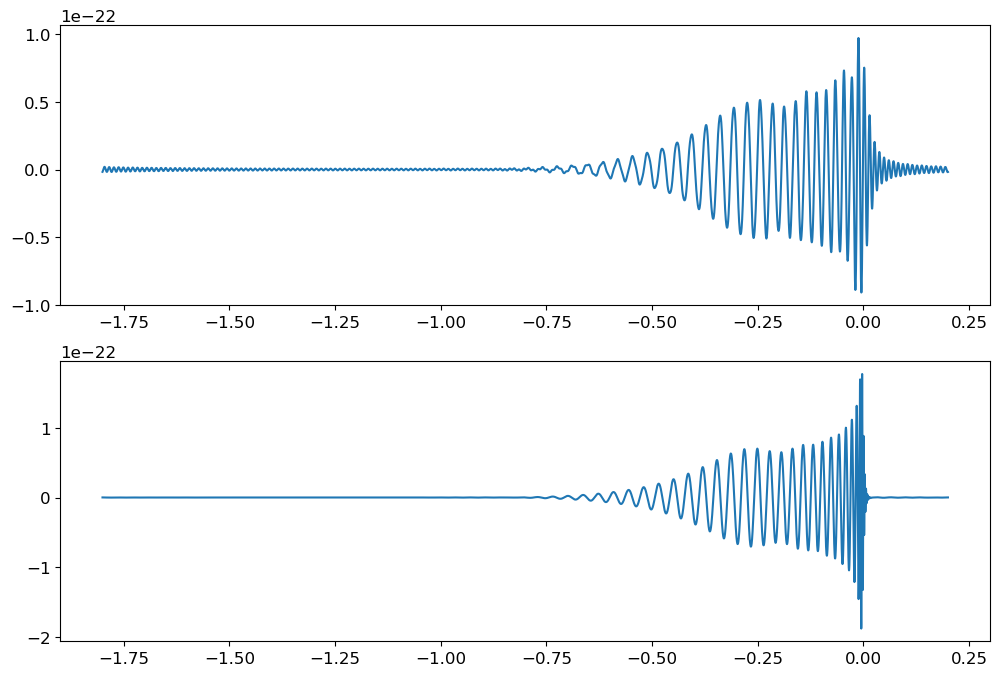

In [8]:
pp.figure(figsize=(12, 8))
pp.subplot(211)
h1_bns.plot()
pp.subplot(212)
h1_bbh.plot()

In [9]:
h1_bbh.resize(len(ts1))
h1_bns.resize(len(ts1))

h1_bbh = h1_bbh.cyclic_time_shift(h1_bbh.sample_times[-1])
h1_bns = h1_bns.cyclic_time_shift(h1_bns.sample_times[-1])

In [10]:
# useful later for inner prod with itself
sigma_bbh = sigma(h1_bbh, psd=psd, low_frequency_cutoff=30)
sigma_bns = sigma(h1_bns, psd=psd, low_frequency_cutoff=30)

h1_bbh.data /= sigma_bbh
h1_bns.data /= sigma_bns

print(sigma_bbh, sigma_bns)

9.66463076167198 6.286997120831274


In [11]:
rho_B, _, _, _, _ = gen_SNR(h1_bbh, ts1, psd)
rho_N, _, _, _, _ = gen_SNR(h1_bns, ts1, psd)

In [12]:
rho_strong_B, _, _, _, _ = gen_SNR(h1_bbh, ts1_strong_bbh, psd)
rho_strong_N, _, _, _, _ = gen_SNR(h1_bns, ts1_strong_bns, psd)

In [13]:
rho_noise, _, _, _, _ = gen_SNR(h1_bns, noise, psd)

(35.2, 36.3)

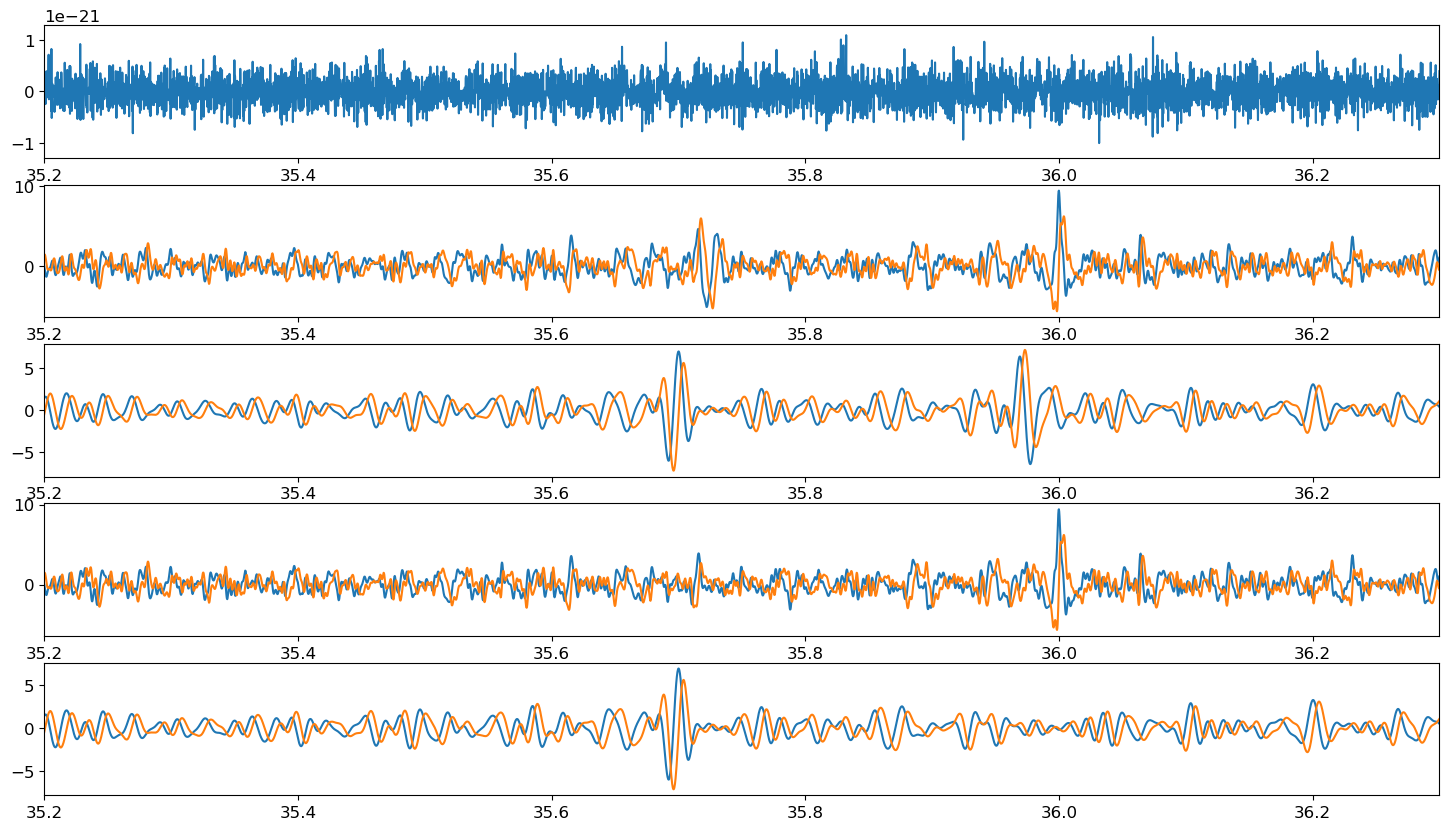

In [14]:
xmin, xmax = 35.2, 36.3
pp.figure(figsize=(18, 10))
pp.subplot(511)
ts1.plot()
pp.xlim([xmin, xmax])
pp.subplot(512)
rho_B.plot()
pp.xlim([xmin, xmax])
pp.subplot(513)
rho_N.plot()
pp.xlim([xmin, xmax])
pp.subplot(514)
rho_strong_B.plot()
pp.xlim([xmin, xmax])
pp.subplot(515)
rho_strong_N.plot()
pp.xlim([xmin, xmax])

In [16]:
x_bb, _, _, _, _ = gen_SNR(h1_bbh, h1_bbh, psd)
x_bn, _, _, _, _ = gen_SNR(h1_bns, h1_bbh, psd)
x_nb, _, _, _, _ = gen_SNR(h1_bbh, h1_bns, psd)
x_nn, _, _, _, _ = gen_SNR(h1_bns, h1_bns, psd)

([<matplotlib.lines.Line2D at 0x7fbc0971c7d0>],
 [<matplotlib.lines.Line2D at 0x7fbc0971cad0>])

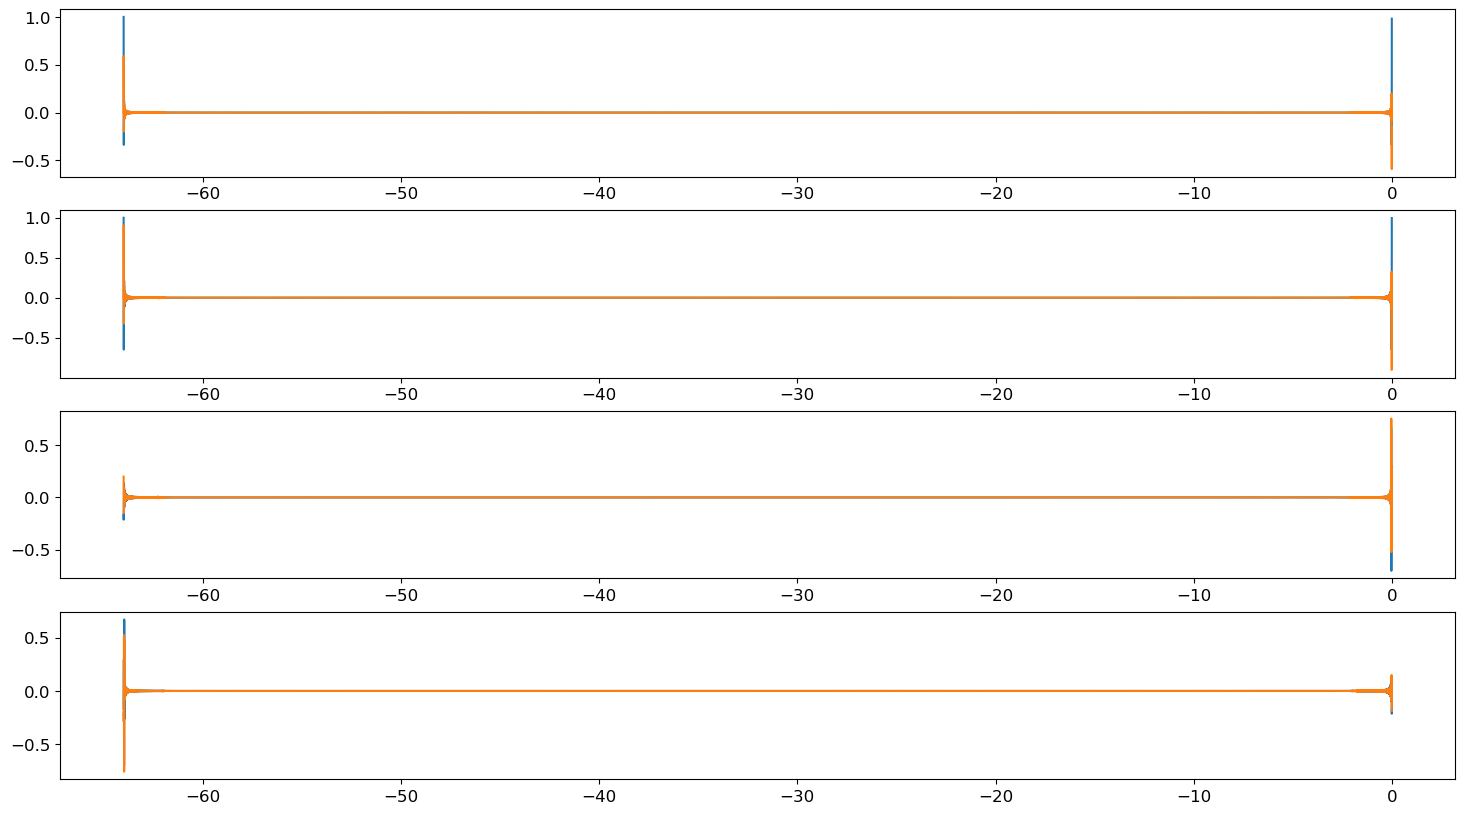

In [17]:
pp.figure(figsize=(18, 10))
pp.subplot(411)
x_bb.plot()
pp.subplot(412)
x_nn.plot()
pp.subplot(413)
x_bn.plot()
pp.subplot(414)
x_nb.plot()

### Check if order of MF and shifting affects things

In [477]:
h1_bns_shiftd_tmp = shift_timeseries(h1_bns.real(), 100)
shifted_nb = shift_timeseries(x_nb.real(), 100)
x_nb_tmp, _, _, _, _ = gen_SNR(h1_bbh, h1_bns_shiftd_tmp, psd)

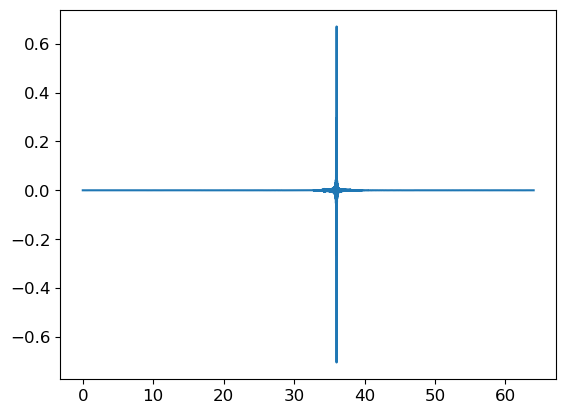

In [479]:
shifted_nb.real().plot()
# (x_nb_tmp-shifted_nb).real().plot()

### Validation check: Try to reconstruct rho_bbh from Ab, x_bb, An and x_nb

(98.5, 100.5)

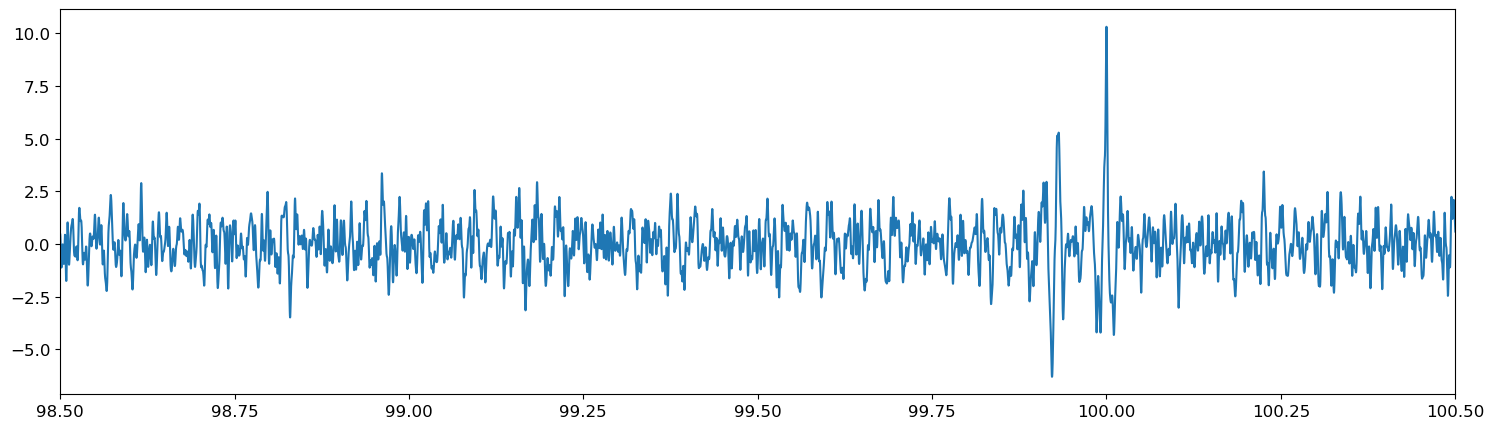

In [ ]:
xmin, xmax = 98.5, 100.5
pp.figure(figsize=(18,5))
rho_B.real().plot()
pp.xlim((xmin, xmax))

(98.5, 100.5)

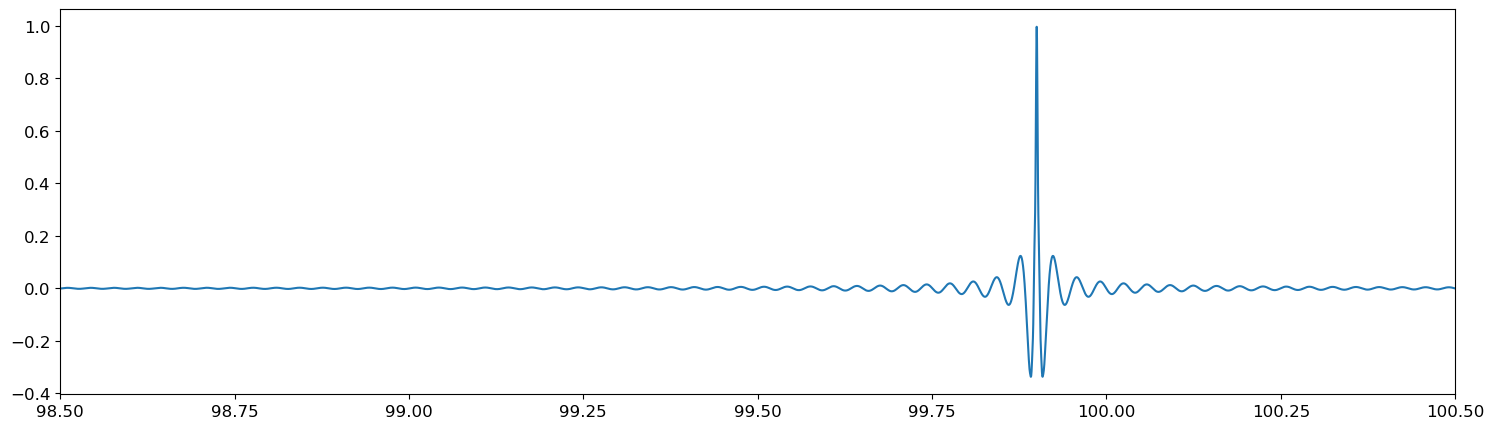

In [ ]:
pp.figure(figsize=(18,5))
shifted_bbh = shift_timeseries(x_bb.real(), (100-buffer))
shifted_bbh.plot()
pp.xlim((xmin, xmax))

(98.5, 100.5)

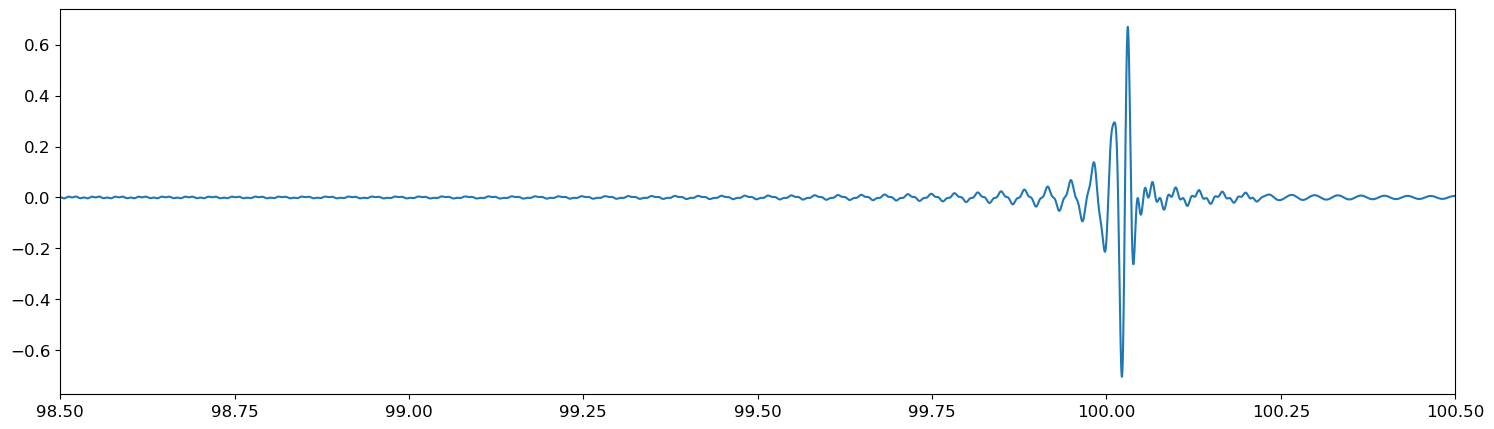

In [ ]:
pp.figure(figsize=(18,5))
shifted_nb = shift_timeseries(x_nb.real(), 100)
shifted_nb.plot()
pp.xlim((xmin, xmax))

In [ ]:
Ab = sigma_bbh
An = sigma_bns
rho_b_rec = Ab * shifted_bbh + An * shifted_nb

(98.5, 100.5)

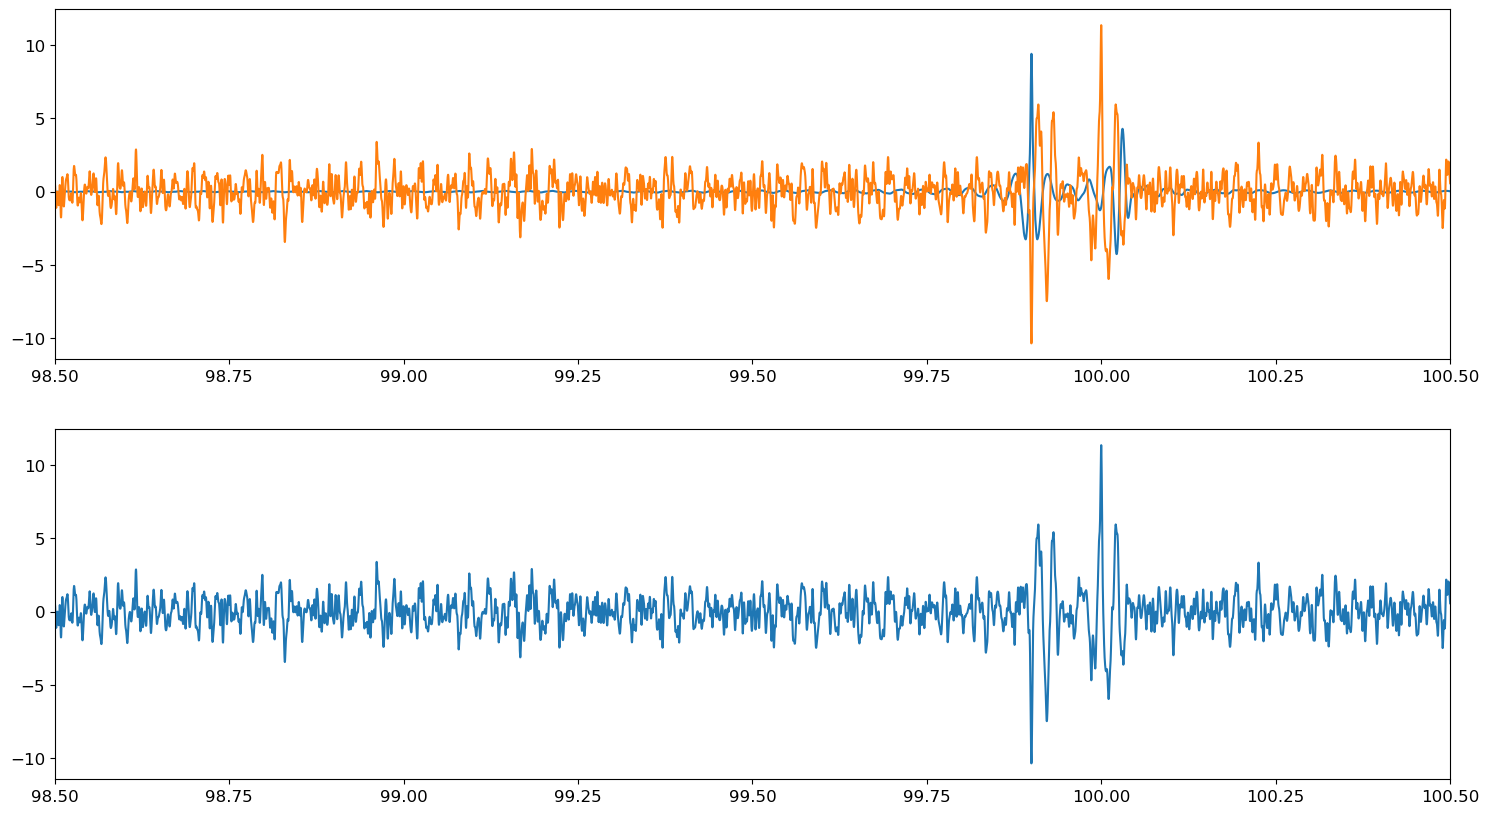

In [ ]:
pp.figure(figsize=(18,10))
pp.subplot(211)
rho_b_rec.plot()
(rho_B.real() - rho_b_rec).plot()
# pp.ylim((-2000, 2000))
pp.xlim((xmin, xmax))
pp.subplot(212)
(rho_B.real() - rho_b_rec).plot()
# pp.ylim((-2000, 2000))
pp.xlim((xmin, xmax))

### Validation check: Try to reconstruct rho_bns from Ab, x_nb_conj, An and x_nn

(99.0, 101.0)

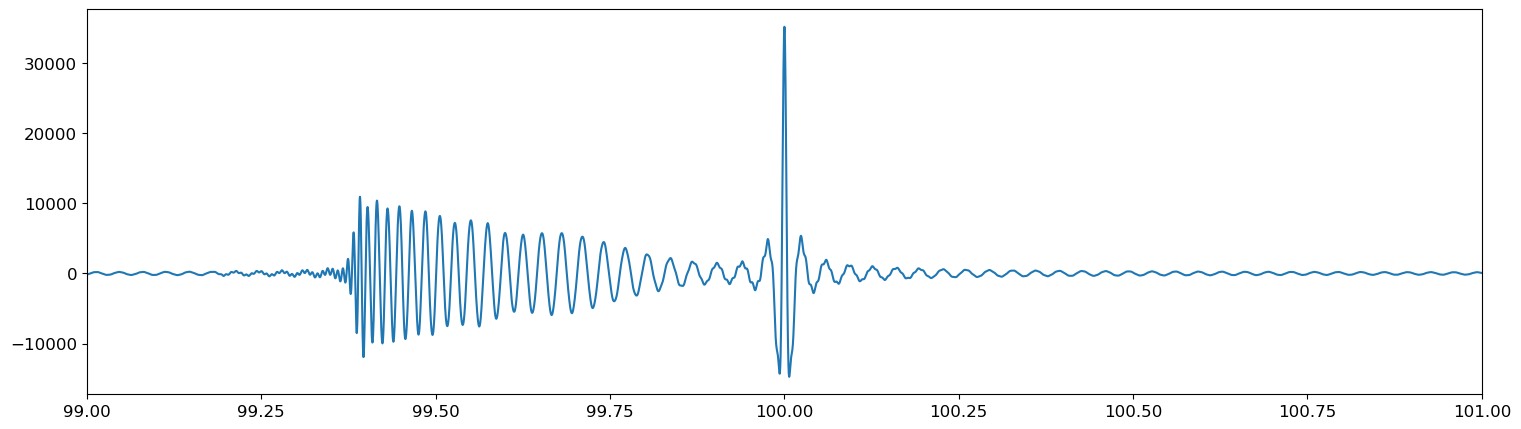

In [ ]:
xmin, xmax = 99, 101
pp.figure(figsize=(18,5))
rho_N.real().plot()
pp.xlim((xmin, xmax))

(99.0, 101.0)

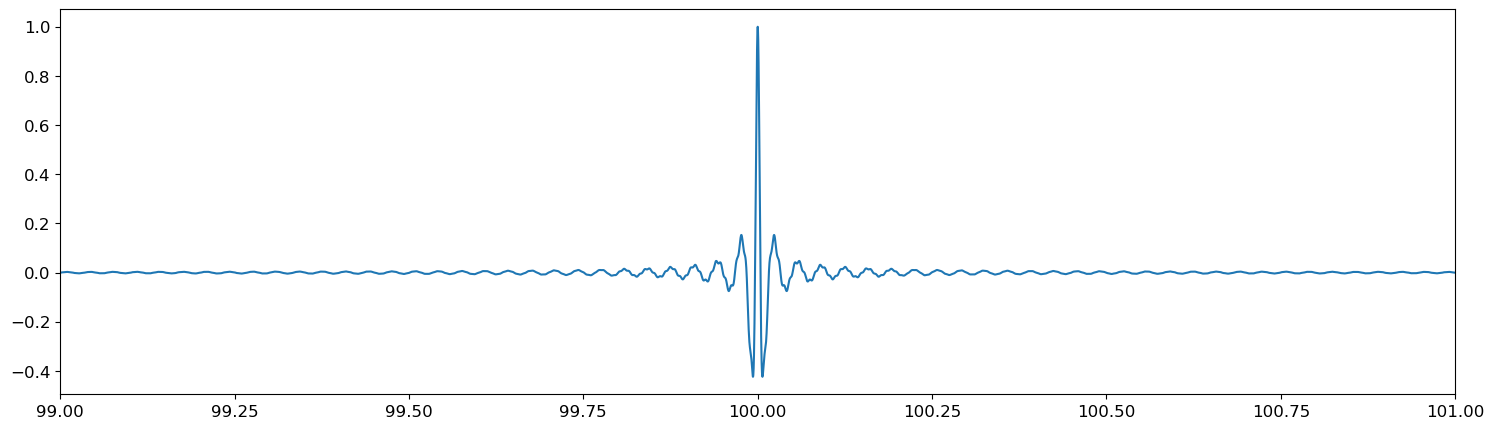

In [ ]:
pp.figure(figsize=(18,5))
shifted_bns = shift_timeseries(x_nn.real(), 100)
shifted_bns.plot()
pp.xlim((xmin, xmax))

(99.0, 101.0)

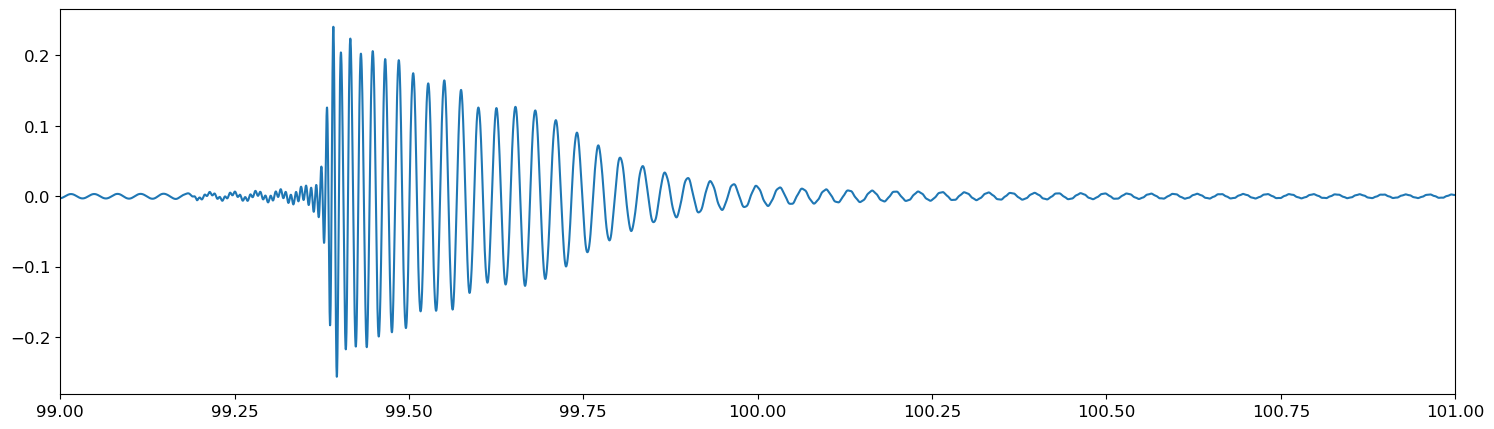

In [ ]:
pp.figure(figsize=(18,5))
shifted_bn = shift_timeseries(x_bn.real(), (100-buffer))
shifted_bn.plot()
pp.xlim((xmin, xmax))

In [ ]:
Ab = sigma_bbh
An = sigma_bns
rho_n_rec = Ab * shifted_bn + An * shifted_bns

(99.0, 101.0)

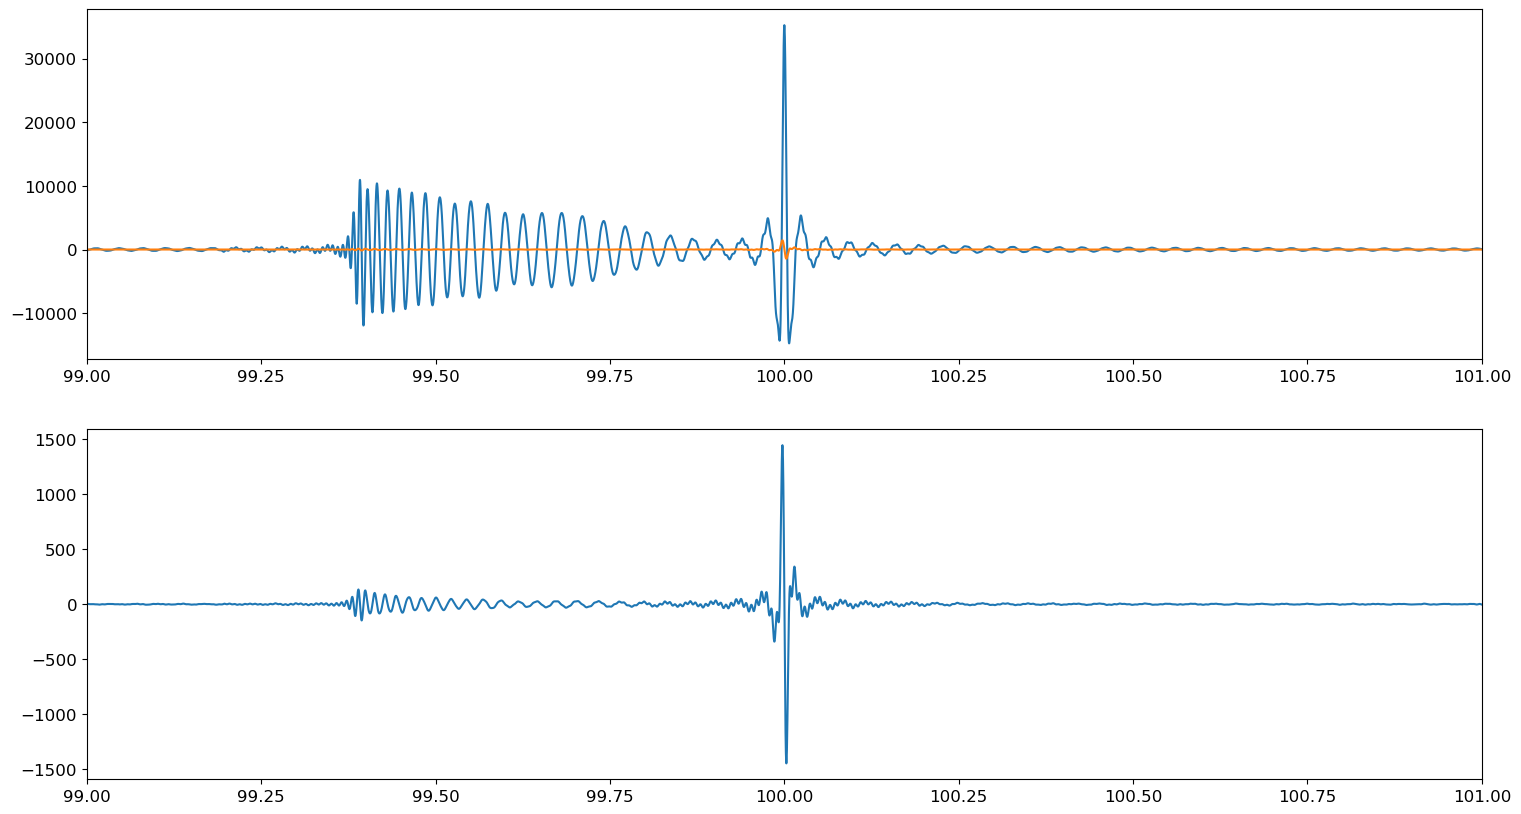

In [ ]:
pp.figure(figsize=(18,10))
pp.subplot(211)
rho_n_rec.plot()
(rho_n_rec - rho_N.real()).plot()
# pp.ylim((-2000, 2000))
pp.xlim((xmin, xmax))
pp.subplot(212)
(rho_n_rec - rho_N.real()).plot()
# pp.ylim((-2000, 2000))
pp.xlim((xmin, xmax))

### looks good! Now reusing x_nb to get x_bn

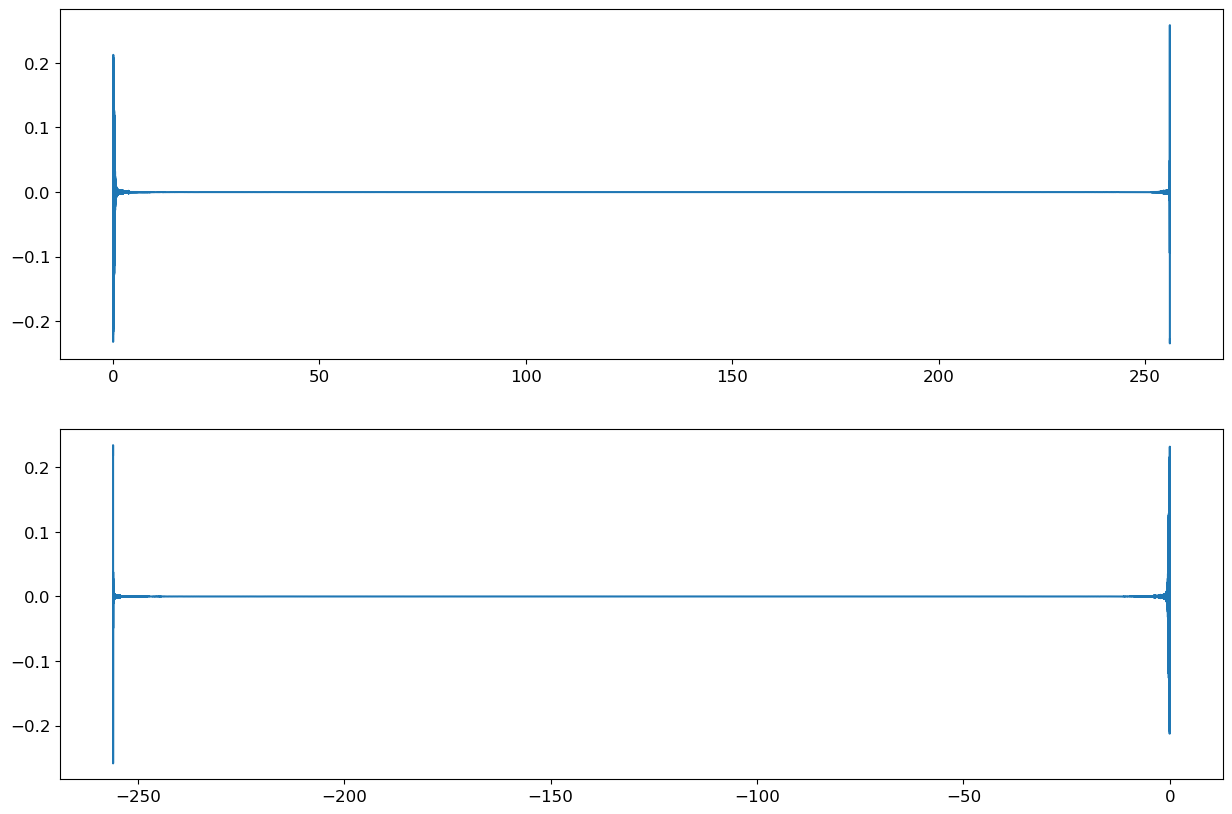

In [ ]:
# x_bn_shifted = x_bn.real()
# x_nb_shifted = x_nb.real()
x_bn_shifted = x_bn.imag()
x_nb_shifted = x_nb.imag()

x_bn_shifted.start_time = x_nb_shifted.end_time

pp.figure(figsize=(15,10))
pp.subplot(211)
x_bn_shifted.plot()
pp.subplot(212)
x_nb_shifted.plot()

In [ ]:
tau = 100
x_bn_shifted.data = x_bn_shifted.data[::-1]

In [ ]:
x_bn_shifted = x_bn_shifted.cyclic_time_shift(tau)
x_nb_shifted = x_nb_shifted.cyclic_time_shift(-x_nb_shifted.duration+tau)

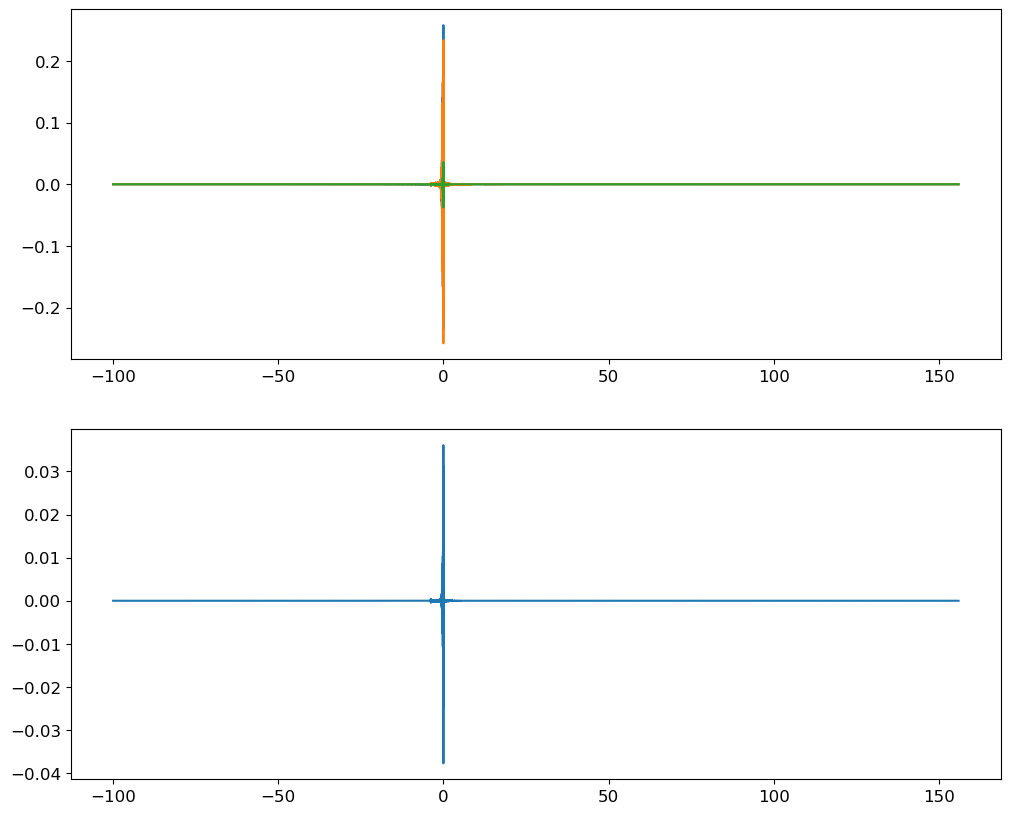

In [ ]:
xmin, xmax = -0.1, 0
# xmin, xmax = int(x_bn_shifted.start_time), int(x_bn_shifted.end_time)

pp.figure(figsize=(12,10))
pp.subplot(211)
x_bn_shifted.plot()
x_nb_shifted.plot()
(x_bn_shifted+x_nb_shifted).plot()
# pp.xlim((xmin, xmax))
pp.subplot(212)
# x_nb_shifted.plot()
(x_bn_shifted+x_nb_shifted).plot()
# pp.xlim((xmin, xmax))

([<matplotlib.lines.Line2D at 0x7ff40a5e1c50>],
 [<matplotlib.lines.Line2D at 0x7ff40a5e1f50>])

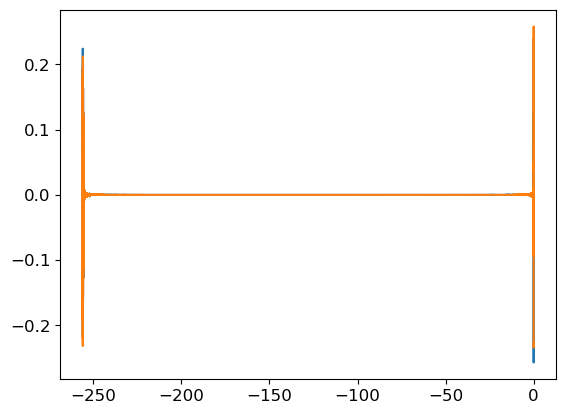

In [ ]:
x_bn.plot()

In [ ]:
x_nb_conj_shifted = x_bn.copy()
x_nb_conj_shifted.data = np.conj(x_nb_conj_shifted.data[::-1])

(-0.1, 0.0)

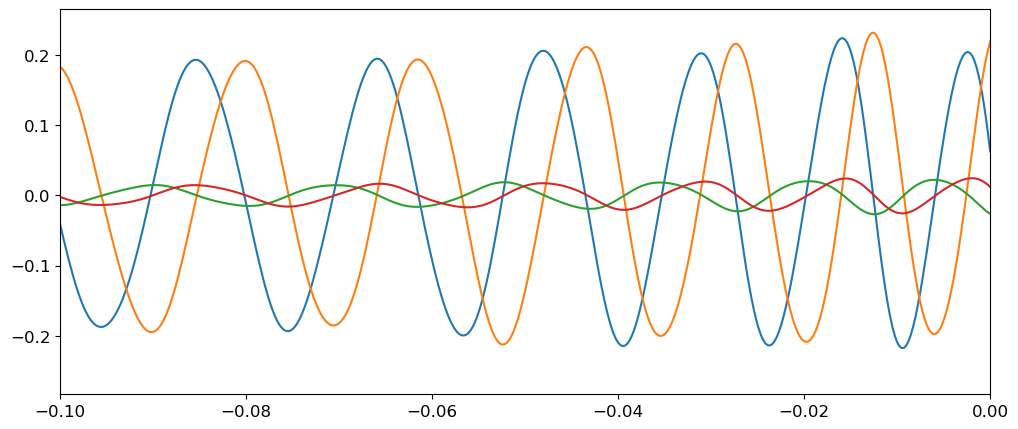

In [ ]:
pp.figure(figsize=(12,5))
x_nb_conj_shifted.plot()
(x_nb_conj_shifted-x_nb).plot()
pp.xlim((xmin, xmax))

### Get $A_B$ and $A_N$ from formula

$$ s(t) = n(t) + h(t) $$
$$ h(t) = A_B g_B(t-\tau_B) + A_N g_N(t-\tau_N) $$

Matched filters:

$$ \rho_B(t) = (s,g_B)(t) = A_B x_{BB}(t-\tau_B) + A_N x_{NB}(t-\tau_N) + (n,g_B) $$
$$ \rho_N(t) = (s,g_N)(t) = A_B x_{BN}(t-\tau_B) + A_N x_{NN}(t-\tau_N) + (n,g_N) $$

Solving these by ignoring $(n,g)$ terms:

$$ A_B(t) = \frac{\rho_B(t) \cdot x_{NN}(t-\tau_N) - \rho_N(t) \cdot x_{NB}(t-\tau_N)}{x_{BB}(t-\tau_B) \cdot x_{NN}(t-\tau_N) - x_{BN}(t-\tau_B) \cdot x_{NB}(t-\tau_N)} $$
$$ A_N(t) = \frac{\rho_B(t) \cdot x_{BN}(t-\tau_B) - \rho_N(t) \cdot x_{BB}(t-\tau_B)}{x_{NB}(t-\tau_N) \cdot x_{BN}(t-\tau_B) - x_{NN}(t-\tau_N) \cdot x_{BB}(t-\tau_B)} $$

In [510]:
xmin, xmax = 35., 37.

In [529]:
shifted_bbh = shift_timeseries(x_bb, (36-buffer))
shifted_nb = shift_timeseries(x_nb, 36)
shifted_bns = shift_timeseries(x_nn, 36)
shifted_bn = shift_timeseries(x_bn, (36-buffer))

In [530]:
A_B_num = rho_B * shifted_bns - rho_N * shifted_nb
A_B_den = shifted_bbh * shifted_bns - shifted_bn * shifted_nb

A_N_num = rho_B * shifted_bn - rho_N * shifted_bbh
A_N_den = shifted_nb * shifted_bn - shifted_bns * shifted_bbh

In [527]:
# A_B_den.data[abs(A_B_den.data)<max(abs(A_B_den.data))/5] = 100000
# A_N_den.data[abs(A_N_den.data)<max(abs(A_N_den.data))/5] = 100000

(35.2, 36.3)

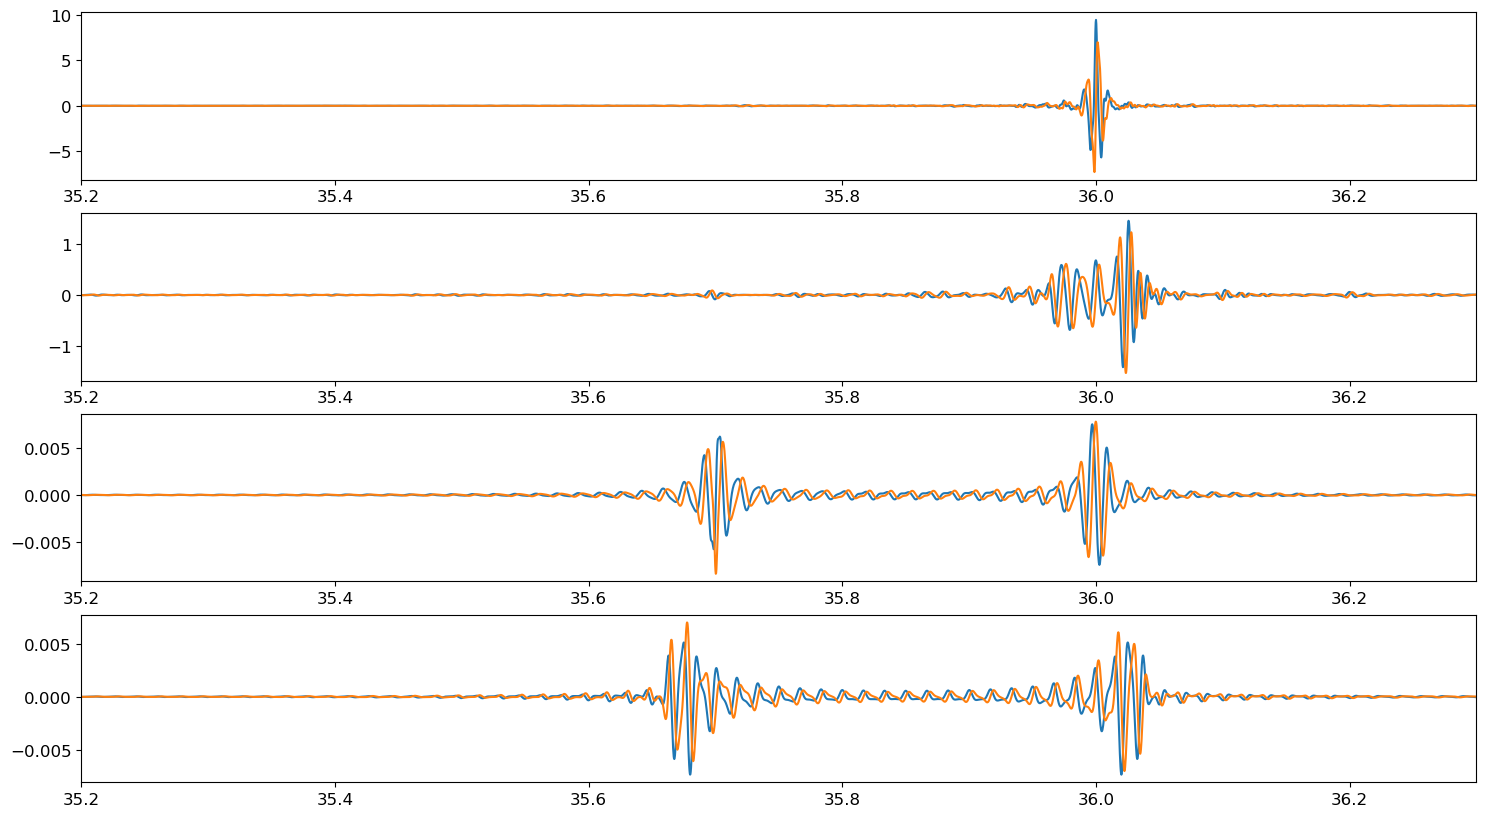

In [528]:
pp.figure(figsize=(18, 10))

pp.subplot(411)
(rho_B * shifted_bns).plot()
pp.xlim((xmin, xmax))

pp.subplot(412)
(rho_N * shifted_nb).plot()
pp.xlim((xmin, xmax))

pp.subplot(413)
(shifted_bbh * shifted_bns).plot()
pp.xlim((xmin, xmax))

pp.subplot(414)
(shifted_bn * shifted_nb).plot()
pp.xlim((xmin, xmax))

(35.2, 36.3)

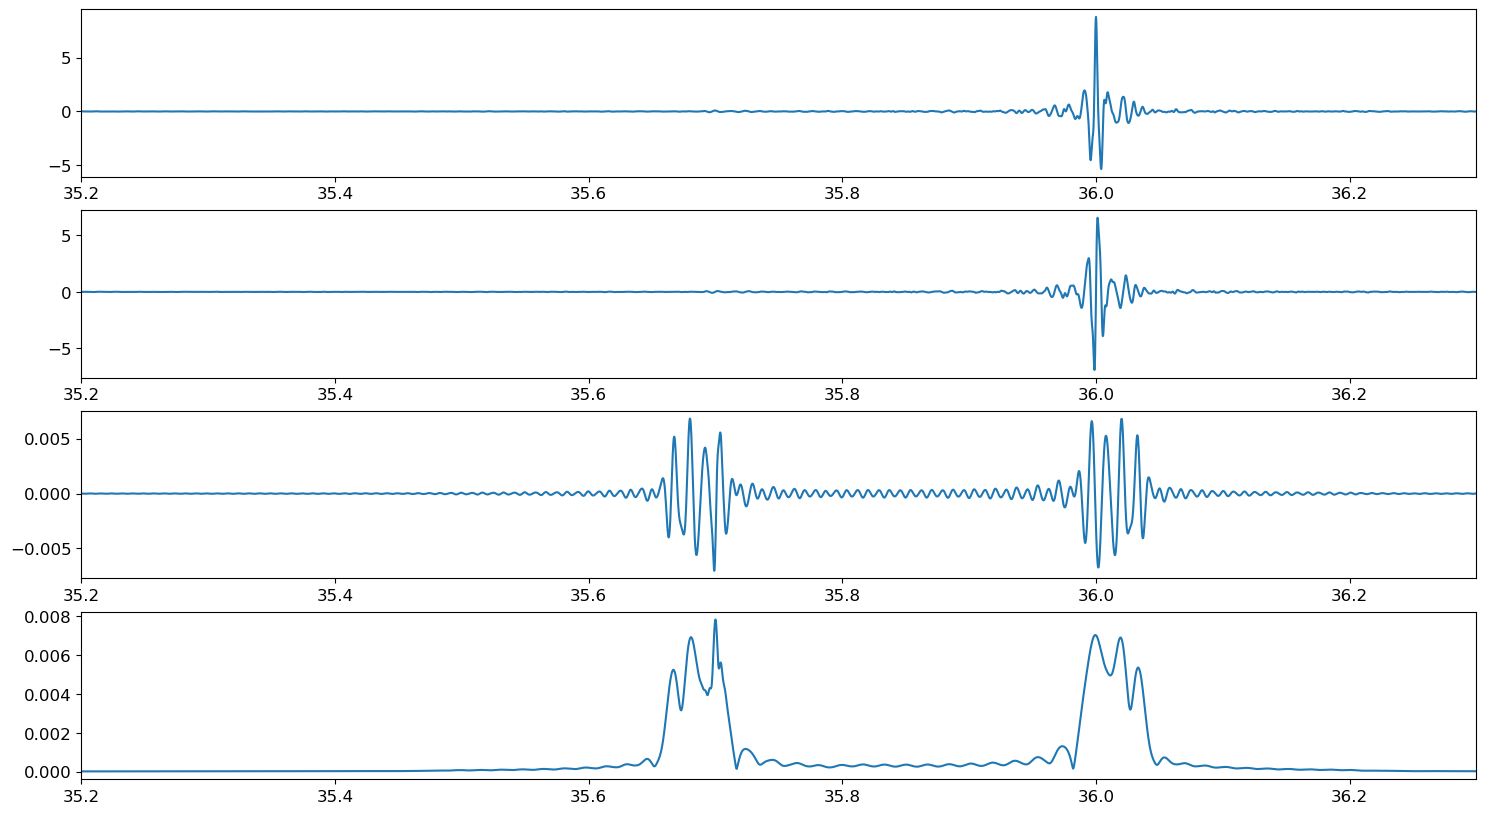

In [531]:
# xmin, xmax = 90, 110.25
num, den = A_B_num, A_B_den
# num, den = A_N_num, A_N_den

pp.figure(figsize=(18, 10))

pp.subplot(411)
num.real().plot()
pp.xlim((xmin, xmax))

pp.subplot(412)
num.imag().plot()
pp.xlim((xmin, xmax))

pp.subplot(413)
den.real().plot()
pp.xlim((xmin, xmax))

pp.subplot(414)
abs(den).plot()
pp.xlim((xmin, xmax))

In [ ]:
# A_B = A_B_num * A_B_den.conj() / abs(A_B_den)**2
A_B = A_B_num / A_B_den
# A_N = A_N_num * A_N_den.conj() / abs(A_N_den)**2
A_N = A_N_num / A_N_den

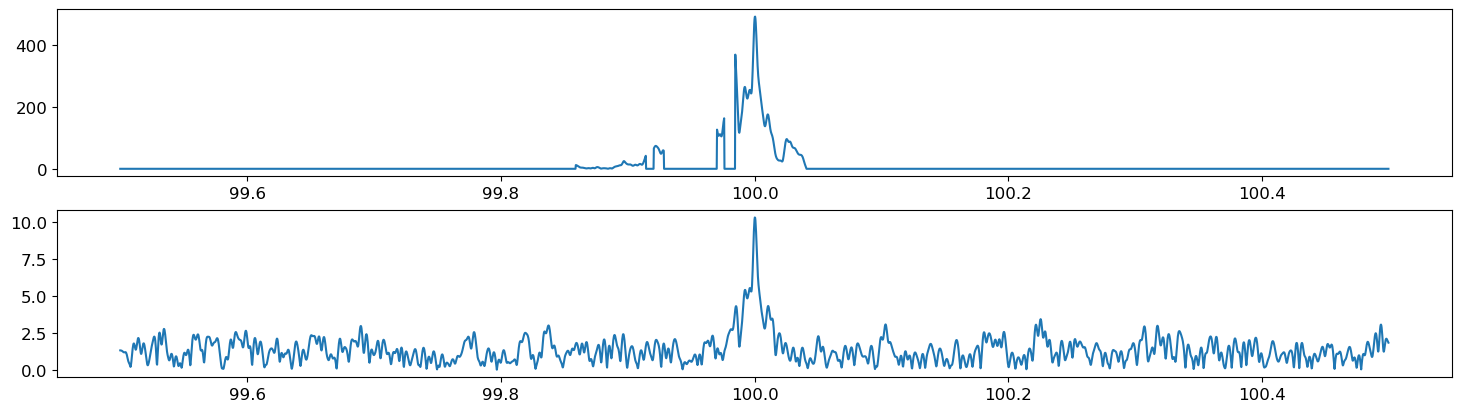

In [ ]:
pp.figure(figsize=(18, 10))
pp.subplot(411)
abs(A_B).time_slice(xmin, xmax).plot()
# pp.xlim((xmin, xmax))
pp.subplot(412)
abs(rho_strong_B).time_slice(xmin, xmax).plot()
# pp.yscale('log')
# pp.xlim((xmin, xmax))

(99.5, 100.5)

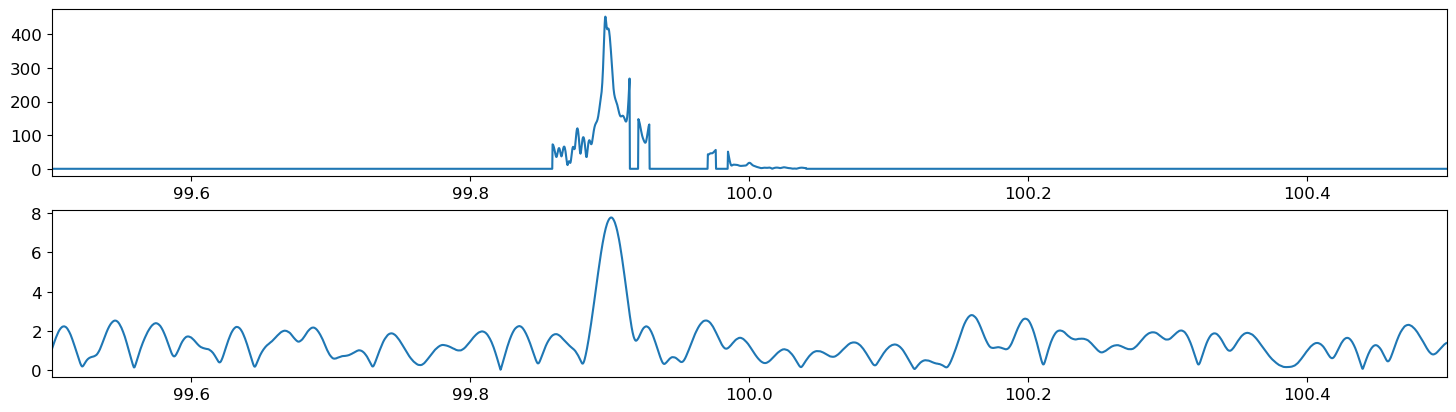

In [ ]:
pp.figure(figsize=(18, 10))
pp.subplot(411)
abs(A_N).time_slice(xmin, xmax).plot()
pp.xlim((xmin, xmax))
pp.subplot(412)
abs(rho_strong_N).time_slice(xmin, xmax).plot()
# pp.yscale('log')
pp.xlim((xmin, xmax))

In [ ]:
rho = A_B * rho_B + A_N * rho_N

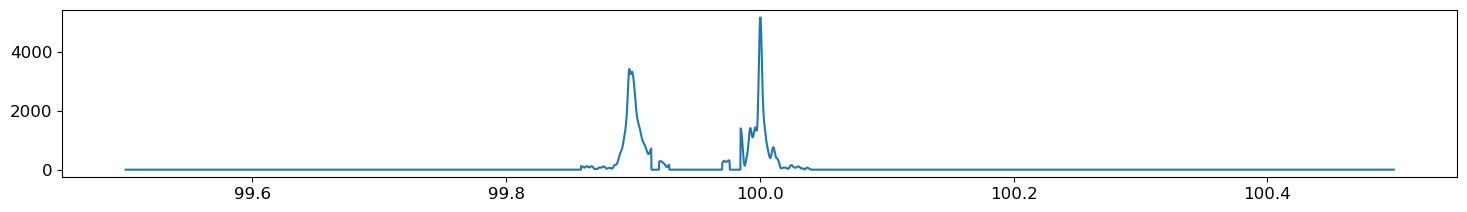

In [ ]:
pp.figure(figsize=(18, 10))
pp.subplot(411)
abs(rho).time_slice(xmin, xmax).plot()

(35.5, 36.5)

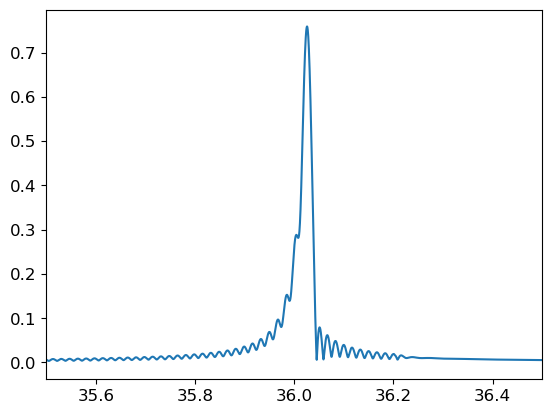

In [533]:
abs(shifted_nb).plot()
pp.xlim(35.5,36.5)

---

### Trial: maximisation with subtration

In [18]:
rho_B, tpeak_B_new, _, _, cSNR_B_new = gen_SNR(h1_bbh, ts1, psd)
rho_N, tpeak_N_new, _, _, cSNR_N_new = gen_SNR(h1_bns, ts1, psd)

In [19]:
print(tpeak_B_new, tpeak_N_new)

36.0 35.697509765625


In [20]:
shifted_bn = shift_timeseries(x_bn, tpeak_B_new)
rho_N_new = rho_N - cSNR_B_new * shifted_bn

([<matplotlib.lines.Line2D at 0x7fbc53cecdd0>],
 [<matplotlib.lines.Line2D at 0x7fbc53cfa110>])

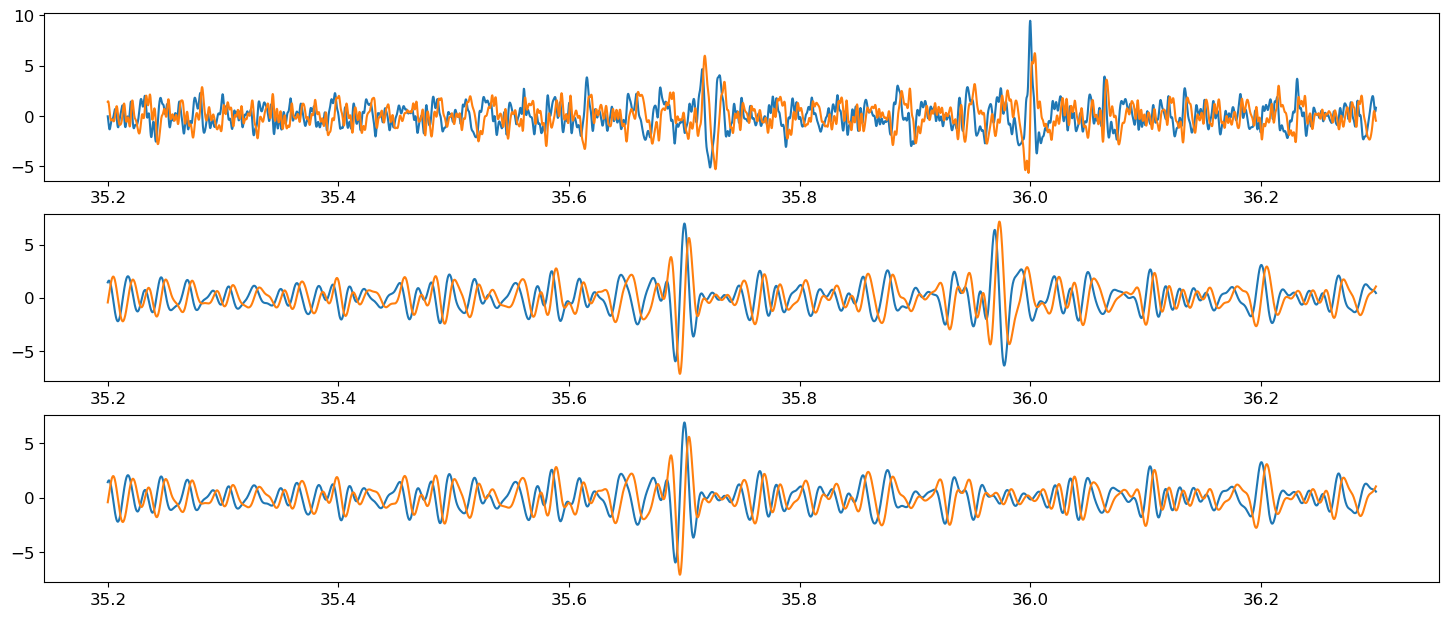

In [21]:
pp.figure(figsize=(18, 10))
pp.subplot(411)
rho_B.time_slice(xmin, xmax).plot()
pp.subplot(412)
rho_N.time_slice(xmin, xmax).plot()
pp.subplot(413)
rho_N_new.time_slice(xmin, xmax).plot()

In [ ]:
tpeak_N_new, _, _, cSNR_N_new = find_peak(rho_N_new)

In [ ]:
for i in range(3):
    # find/refine BNS
    shifted_bn = shift_timeseries(x_bn, tpeak_B_new)
    rho_N_new = rho_N - cSNR_B_new * shifted_bn
    tpeak_N_new, _, _, cSNR_N_new = find_peak(rho_N_new)

    # refine BBH
    shifted_nb = shift_timeseries(x_nb, tpeak_N_new)
    rho_B_new = rho_B - cSNR_N_new * shifted_nb
    tpeak_B_new, _, _, cSNR_B_new = find_peak(rho_B_new)
    
    print(tpeak_B_new, tpeak_N_new, abs(cSNR_B_new), abs(cSNR_N_new))

    # pp.figure(figsize=(18, 5))
    # pp.subplot(211)
    # rho_B_new.time_slice(xmin, xmax).plot()
    # pp.subplot(212)
    # rho_N_new.time_slice(xmin, xmax).plot()
    # pp.show()

100.000244140625 99.901123046875 10.262841528118141 7.7060900778528
100.000244140625 99.901123046875 10.26238032884584 7.718086046595209
100.000244140625 99.901123046875 10.262379610903876 7.718104720561463


In [ ]:
tpeak_strong_B, _, _, cSNR_strong_B = find_peak(rho_strong_B)
tpeak_strong_N, _, _, cSNR_strong_N = find_peak(rho_strong_N)

In [ ]:
print(tpeak_strong_B, tpeak_strong_N, abs(cSNR_strong_B), abs(cSNR_strong_N))

100.000244140625 99.901123046875 10.311447030844196 7.774647323066322


***

## Bank search algorithm

### Overlap search

In [24]:
def match_other_best_template(itrig1, bank, psd, width=0.15):
    rho_N = bank[itrig1]['snr']
    h1_bns = bank[itrig1]['template']
    tpeak = bank[itrig1]['tpeak']
    x_nn = bank[itrig1]['inner']

    xmin, xmax = tpeak-1.2, tpeak+1.2

    shifted_bns = shift_timeseries(x_nn, tpeak)

    max_snr = 0

    for i, t in enumerate(bank):
        # if i == itrig1:
        #     continue
        # else:
            print(f"({t['m1']}, {t['m2']})")
            rho_B = t['snr']
            h1_bbh = t['template']
            x_bb = t['inner']

            # pp.figure(figsize=(15, 3))
            # abs(rho_B).plot()
            # abs(rho_N).plot()
            # pp.xlim(xmin, xmax)
            # pp.show()

            x_bn, _, _, _, _ = gen_SNR(h1_bns, h1_bbh, psd)
            x_nb, _, _, _, _ = gen_SNR(h1_bbh, h1_bns, psd)
            shifted_nb = shift_timeseries(x_nb, tpeak)

            # for buffer in [-1., -0.3]:
            for buffer in np.arange(-0.3, 0.3, 0.1):
                shifted_bbh = shift_timeseries(x_bb, (tpeak+buffer))
                shifted_bn = shift_timeseries(x_bn, (tpeak+buffer))

                A_B_num = rho_B * shifted_bns - rho_N * shifted_nb
                A_B_den = shifted_bbh * shifted_bns - shifted_bn * shifted_nb

                A_N_num = rho_B * shifted_bn - rho_N * shifted_bbh
                A_N_den = shifted_nb * shifted_bn - shifted_bns * shifted_bbh

                A_B_den.data[abs(A_B_den.data)<max(abs(A_B_den.data))/5] = 100000
                A_N_den.data[abs(A_N_den.data)<max(abs(A_N_den.data))/5] = 100000
                A_B = A_B_num / A_B_den
                A_N = A_N_num / A_N_den
                rho = A_B * rho_B + A_N * rho_N

                # pp.figure(figsize=(15, 6))
                # pp.subplot(311)
                # abs(A_B_num).plot()
                # pp.xlim(xmin, xmax)
                # pp.subplot(312)
                # abs(A_B_den).plot()
                # pp.xlim(xmin, xmax)
                # # pp.ylim(0, 1)
                # pp.subplot(313)
                # abs(A_B).plot()
                # pp.xlim(xmin, xmax)
                # pp.show()

                # pp.figure(figsize=(15, 6))
                # pp.subplot(311)
                # abs(A_N_num).plot()
                # pp.xlim(xmin, xmax)
                # pp.subplot(312)
                # abs(A_N_den).plot()
                # pp.xlim(xmin, xmax)
                # # pp.ylim(0, 1)
                # pp.subplot(313)
                # abs(A_N).plot()
                # pp.xlim(xmin, xmax)
                # pp.show()

                tpeak2, _, snrp, _ = find_peak(rho, mask_between=(tpeak-width, tpeak+width))

                if snrp > max_snr:
                    itrig2 = i
                    max_snr = snrp
                    tpeak2_best = tpeak2
                    buffer_best = buffer
                    print(f"({t['m1']}, {t['m2']}) {snrp} {tpeak2} {buffer}")

                    # pp.figure(figsize=(15, 3))
                    # abs(rho).plot()
                    # pp.xlim(xmin, xmax)
                    # # pp.ylim(-0.3, 11)
                    # pp.show()

    return itrig2, max_snr, tpeak2_best, buffer_best, bank

In [187]:
noise, psd = gen_noise(duration=64)
psd = interpolate(psd, noise.delta_f)
psd = inverse_spectrum_truncation(psd, int(4 * noise.sample_rate),
                                  low_frequency_cutoff=30)

In [188]:
m1_1 = 25
m2_1 = 27
m1_2 = 23
m2_2 = 26
buffer = 0.2

h1_bbh = gen_waveform('IMRPhenomPv2', m1_1, m2_1, 0, 0, 50, 0) #/50
h1_bns = gen_waveform('TaylorF2', m1_2, m2_2, 0, 0, 50, 0) #/70
ht_total, _ = overlap(h1_bbh.copy(), h1_bns.copy(), buffer)
ts1 = inject(ht_total, noise, 36)

In [189]:
R_bank = 2
N_bank = 10

np.random.seed(42)
bank = np.append(gen_template_bank(m1_1, m2_1, R_bank, N_bank//2), 
                 gen_template_bank(m1_2, m2_2, R_bank, N_bank//2), 
                 axis=0)

bank = preprocess_bank(bank, len(ts1), psd1=psd)

[25.71344937 26.77172121]
[23.80839785 26.14950319]
[25.17377488 27.2591709 ]
[25.07746461 26.91343177]
[25. 27.]
[23.0404354 25.9922628]
[23.39029608 27.61849065]
[23.14776117 26.33227686]
[22.398862   25.90573192]
[23. 26.]


In [190]:
# 1st run through bank
result1 = MF_bank(ts1, bank, psd)
itrigger1 = best_trig(result1)
print(itrigger1, bank[itrigger1])

Computing SNR for template 1/10
Computing SNR for template 2/10
Computing SNR for template 3/10
Computing SNR for template 4/10
Computing SNR for template 5/10
Computing SNR for template 6/10
Computing SNR for template 7/10
Computing SNR for template 8/10
Computing SNR for template 9/10
Computing SNR for template 10/10
4 {'m1': 25.0, 'm2': 27.0, 'template': <pycbc.types.timeseries.TimeSeries object at 0x7fbbcaa7cb10>, 'inner': <pycbc.types.timeseries.TimeSeries object at 0x7fbc2b0a7590>, 'snr': <pycbc.types.timeseries.TimeSeries object at 0x7fbc09029f90>, 'tpeak': 36.0, 'csnr_peak': (491.17258435803006-5.941771785060542j)}


In [191]:
for t in result1:
    print(f"{t['m1']:.3f}, {t['m2']:.3f}, {t['tpeak']:.6f}, {abs(t['csnr_peak']):.3f}")

25.713, 26.772, 35.999756, 488.284
23.808, 26.150, 36.000977, 434.516
25.174, 27.259, 35.999756, 488.873
25.077, 26.913, 36.000000, 491.194
25.000, 27.000, 36.000000, 491.209
23.040, 25.992, 36.001221, 374.760
23.390, 27.618, 36.000488, 475.505
23.148, 26.332, 36.001221, 403.947
22.399, 25.906, 35.836426, 351.390
23.000, 26.000, 36.001221, 372.301


In [192]:
print(bank[itrigger1]['m1'], bank[itrigger1]['m2'], abs(bank[itrigger1]['csnr_peak']), bank[itrigger1]['tpeak'])

25.0 27.0 491.2085221948942 36.0


In [193]:
def match_other_best_template_simple(itrig1, bank, psd, width=0.15, show_figs=False):
    rho_N = bank[itrig1]['snr']
    h1_bns = bank[itrig1]['template']
    tpeak = bank[itrig1]['tpeak']
    snr_peak_N = abs(bank[itrig1]['csnr_peak'])
    xmin, xmax = tpeak-0.5, tpeak+0.5
    max_snr = 0
    buffer = 0

    for i, t in enumerate(bank):

        # print(f"({t['m1']}, {t['m2']})")
        rho_B = t['snr']
        h1_bbh = t['template']

        # if show_figs:
        #     pp.figure(figsize=(15, 3))
        #     abs(rho_B).plot()
        #     abs(rho_N).plot()
        #     pp.xlim(xmin, xmax)
            # pp.show()

        x_nb, _, _, _, _ = gen_SNR(h1_bbh, h1_bns, psd)
        shifted_nb = shift_timeseries(x_nb, tpeak)

        rho_sub = rho_B - snr_peak_N * shifted_nb

        # chisq_vals = gen_chisquare(h1_bbh, ?, t["m1"], t["m2"], 0, 0, psd)
        # new_snr = newsnr(abs(rho_sub), chisq_vals)

        tpeak2, _, snrp, csnrp = find_peak(rho_sub) #, mask_between=(tpeak-width, tpeak+width)

        bank[i]['csnr_peak'] = csnrp
        bank[i]['tpeak'] = tpeak2

        if snrp > max_snr:
            itrig2 = i
            max_snr = snrp
            tpeak2_best = tpeak2
            buffer_best = buffer

            if show_figs:
                print(f"({t['m1']}, {t['m2']}) {snrp} {tpeak2} {buffer}")
                pp.figure(figsize=(15, 6))
                pp.subplot(311)
                pp.title(f"peak {snr_peak_N:.2f}")
                abs(rho_B).plot()
                # abs(rho_N).plot()
                abs(rho_sub).plot()
                # (rho_sub).plot()
                pp.xlim(xmin, xmax)
                pp.subplot(312)
                abs(snr_peak_N * shifted_nb).plot()
                pp.xlim(xmin, xmax)
                # pp.ylim(-0.3, 11)
                pp.subplot(313)
                abs(rho_sub).plot()
                pp.xlim(xmin, xmax)
                # pp.ylim(-0.3, 11)
                pp.show()

    return itrig2, max_snr, tpeak2_best, buffer_best, bank

(25.713449365904918, 26.77172121256092) 327.6171521158474 35.824462890625 0


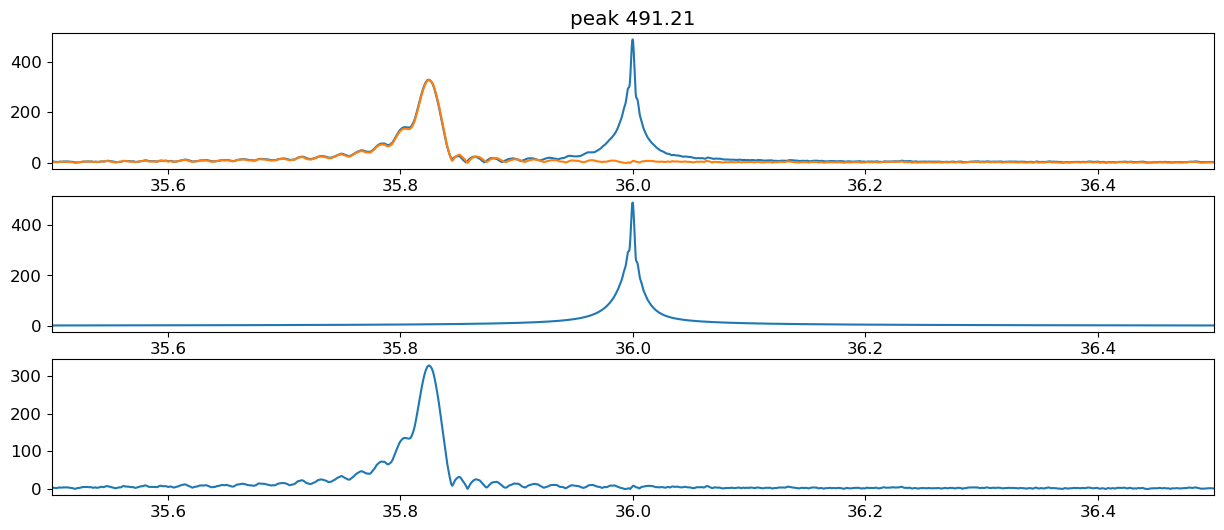

(23.80839784614101, 26.149503186182915) 349.68924743000434 35.8310546875 0


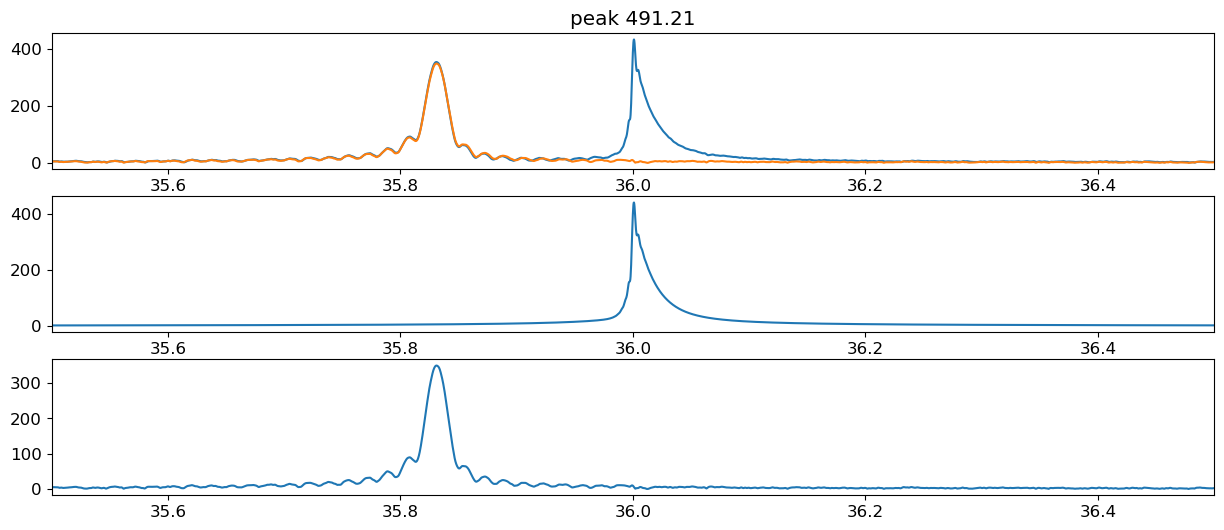

(23.040435396632894, 25.992262796319334) 350.81507670088587 35.833984375 0


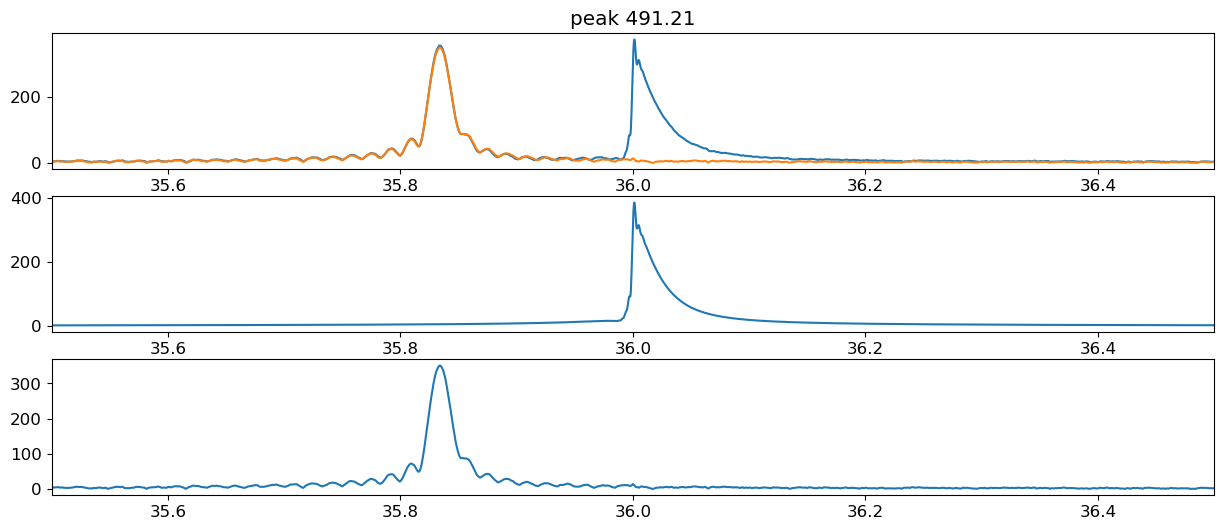

trig2:  5 23.040435396632894 25.992262796319334 350.81507670088587 35.833984375


In [194]:
FIGS = True
# for i in range(1):
# choose best 2nd trigger
itrigger2, max_snr, tpeak2_best, buffer_best, result2 = match_other_best_template_simple(itrigger1, result1, psd, show_figs=FIGS)
print("trig2: ", itrigger2, result2[itrigger2]['m1'], result2[itrigger2]['m2'], abs(result2[itrigger2]['csnr_peak']), result2[itrigger2]['tpeak'])

(25.713449365904918, 26.77172121256092) 515.417111002167 35.825439453125 0


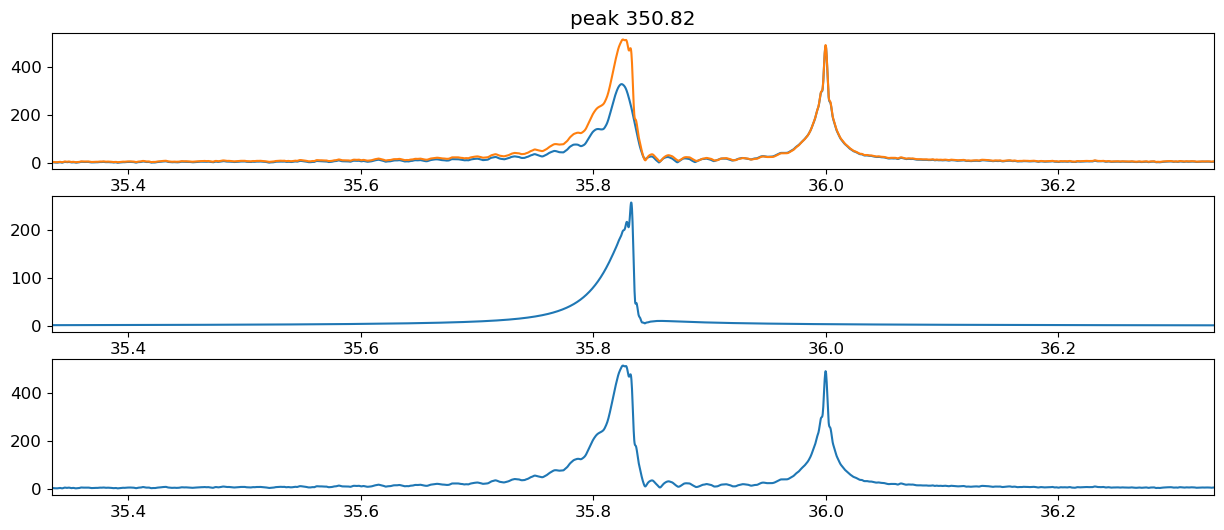

(23.80839784614101, 26.149503186182915) 668.6929957369591 35.833251953125 0


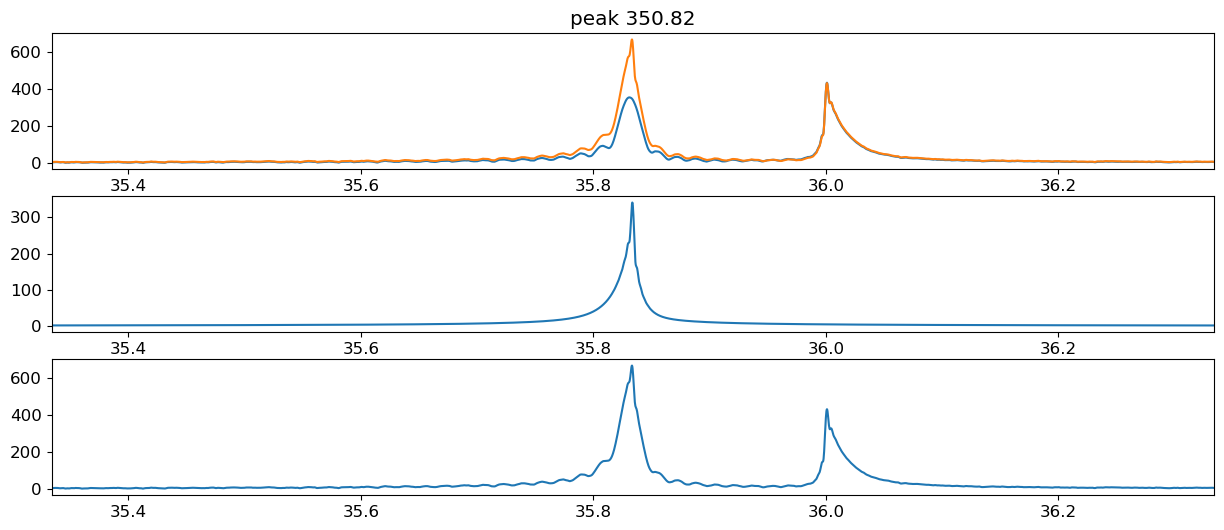

(23.040435396632894, 25.992262796319334) 688.8291005755594 35.833740234375 0


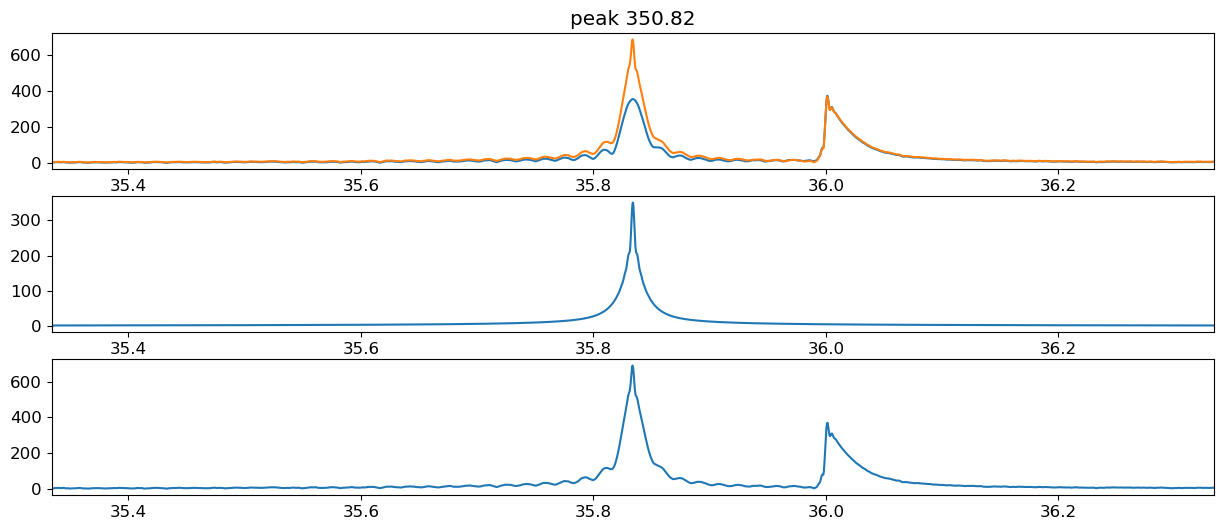

			trig1:  5 23.040435396632894 25.992262796319334 688.8291005755594 35.833740234375


In [183]:
# adjust 1st trigger
itrigger1, max_snr, tpeak2_best, buffer_best, result1 = match_other_best_template_simple(itrigger2, result2, psd, show_figs=FIGS)
print("\t\t\ttrig1: ", itrigger1, result1[itrigger1]['m1'], result1[itrigger1]['m2'], abs(result1[itrigger1]['csnr_peak']), result1[itrigger1]['tpeak'])

In [198]:
# def match_other_best_template_simple(
itrig1, bank, psd = itrigger2, result2, psd
rho_N = bank[itrig1]['snr']
h1_bns = bank[itrig1]['template']
tpeak = bank[itrig1]['tpeak']
snr_peak_N = abs(bank[itrig1]['csnr_peak'])
xmin, xmax = tpeak-0.5, tpeak+0.5
max_snr = 0
buffer = 0

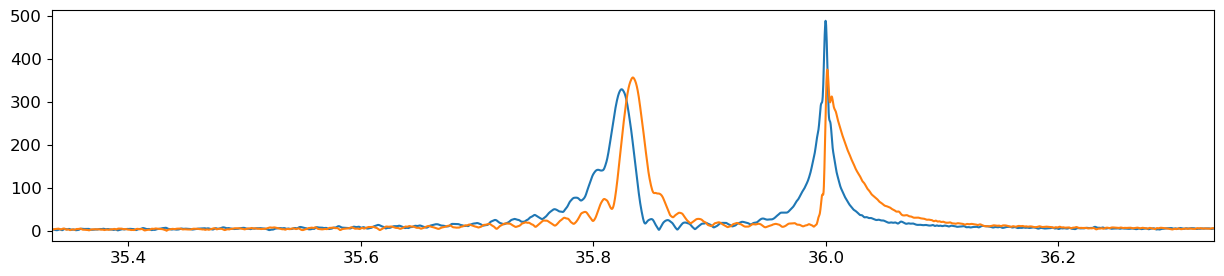

In [199]:
i, t = 0, bank[0]

# print(f"({t['m1']}, {t['m2']})")
rho_B = t['snr']
h1_bbh = t['template']

pp.figure(figsize=(15, 3))
abs(rho_B).plot()
abs(rho_N).plot()
pp.xlim(xmin, xmax)
pp.show()

In [200]:

x_nb, _, _, _, _ = gen_SNR(h1_bbh, h1_bns, psd)
shifted_nb = shift_timeseries(x_nb, tpeak)

(35.533984375, 36.133984375)

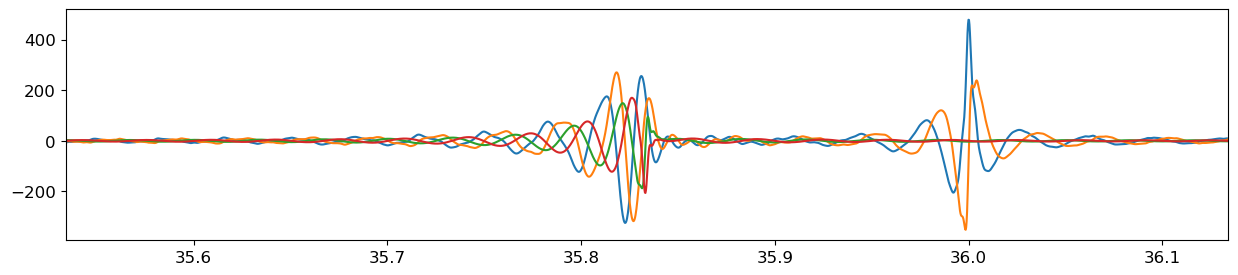

In [209]:
pp.figure(figsize=(15, 3))
rho_B.plot()
(shifted_nb**300).plot()
pp.xlim(xmin+0.2, xmax-0.2)

In [ ]:

rho_sub = rho_B - snr_peak_N * shifted_nb

# chisq_vals = gen_chisquare(h1_bbh, ?, t["m1"], t["m2"], 0, 0, psd)
# new_snr = newsnr(abs(rho_sub), chisq_vals)

tpeak2, _, snrp, csnrp = find_peak(rho_sub) #, mask_between=(tpeak-width, tpeak+width)

bank[i]['csnr_peak'] = csnrp
bank[i]['tpeak'] = tpeak2

if snrp > max_snr:
    itrig2 = i
    max_snr = snrp
    tpeak2_best = tpeak2
    buffer_best = buffer

    if show_figs:
        print(f"({t['m1']}, {t['m2']}) {snrp} {tpeak2} {buffer}")
        pp.figure(figsize=(15, 6))
        pp.subplot(311)
        pp.title(f"peak {snr_peak_N:.2f}")
        abs(rho_B).plot()
        # abs(rho_N).plot()
        abs(rho_sub).plot()
        # (rho_sub).plot()
        pp.xlim(xmin, xmax)
        pp.subplot(312)
        abs(snr_peak_N * shifted_nb).plot()
        pp.xlim(xmin, xmax)
        # pp.ylim(-0.3, 11)
        pp.subplot(313)
        abs(rho_sub).plot()
        pp.xlim(xmin, xmax)
        # pp.ylim(-0.3, 11)
        pp.show()

In [ ]:

# chisq_vals = gen_chisquare(h1_bbh, ?, t["m1"], t["m2"], 0, 0, psd)
# new_snr = newsnr(abs(rho_sub), chisq_vals)

tpeak2, _, snrp, csnrp = find_peak(rho_sub) #, mask_between=(tpeak-width, tpeak+width)

bank[i]['csnr_peak'] = csnrp
bank[i]['tpeak'] = tpeak2

if snrp > max_snr:
    itrig2 = i
    max_snr = snrp
    tpeak2_best = tpeak2
    buffer_best = buffer

return itrig2, max_snr, tpeak2_best, buffer_best, bank

In [ ]:
itrig1, bank = 3, result1
rho_B = bank[itrig1]['snr']
h1_bbh = bank[itrig1]['template']
tpeak = bank[itrig1]['tpeak']
x_bb = bank[itrig1]['inner']

In [ ]:

i = 4
rho_N = t['snr']
h1_bns = t['template']
x_bn, _, _, _, _ = gen_SNR(h1_bns, h1_bbh, psd)
x_nb, _, _, _, _ = gen_SNR(h1_bbh, h1_bns, psd)
x_nn = t['inner']

In [ ]:
buffer = -0.6
shifted_bbh = shift_timeseries(x_bb, (tpeak+buffer))
shifted_nb = shift_timeseries(x_nb, tpeak)
shifted_bns = shift_timeseries(x_nn, tpeak)
shifted_bn = shift_timeseries(x_bn, (tpeak+buffer))

In [ ]:
A_B_num = rho_B * shifted_bns - rho_N * shifted_nb
A_B_den = shifted_bbh * shifted_bns - shifted_bn * shifted_nb

A_N_num = rho_B * shifted_bn - rho_N * shifted_bbh
A_N_den = shifted_nb * shifted_bn - shifted_bns * shifted_bbh

In [ ]:
A_B_den.data[abs(A_B_den.data)<max(abs(A_B_den.data))/5] = 100000
A_N_den.data[abs(A_N_den.data)<max(abs(A_N_den.data))/5] = 100000
A_B = A_B_num / A_B_den
A_N = A_N_num / A_N_den
rho = A_B * rho_B + A_N * rho_N

(99.0, 101.0)

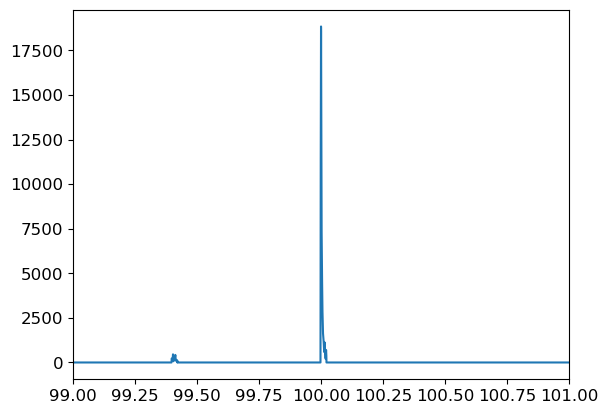

In [ ]:
abs(rho).plot()
# A_B_num.plot()
pp.xlim(99, 101)

(99.0, 101.0)

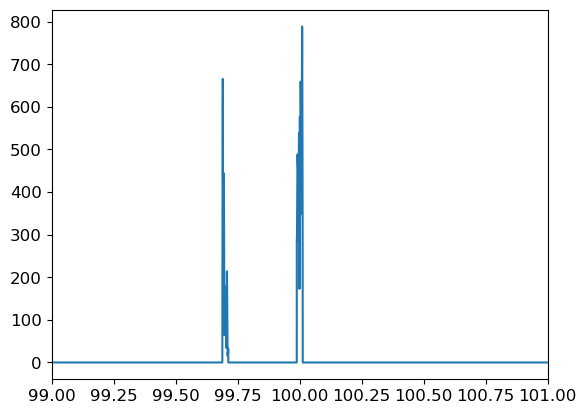

In [ ]:
abs(rho).plot()
# A_B_num.plot()
pp.xlim(99, 101)

In [ ]:
tpeak, peak, snrp, csnrp = find_peak(rho)

In [ ]:
tpeak, abs(csnrp)

(100.01025390625, 788.5497573735012)

### Old Stuff

In [ ]:
import matplotlib.pyplot as pp
import pycbc.noise
import pycbc.psd
import pycbc.filter
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
import numpy as np
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr
import pandas as pd
from pycbc.filter import sigma
import h5py
from pycbc.types import timeseries
from pycbc.types import TimeSeries

%matplotlib inline

In [ ]:
def psd_data(conditioned):

    from pycbc.psd import interpolate, inverse_spectrum_truncation
    # Estimate the power spectral density

    # We use 4 second samples of our time series in Welch method.
    psd = conditioned.psd(4)

    # Now that we have the psd we need to interpolate it to match our data
    # and then limit the filter length of 1 / PSD. After this, we can
    # directly use this PSD to filter the data in a controlled manner

    psd = interpolate(psd, conditioned.delta_f)

    # 1/PSD will now act as a filter with an effective length of 4 seconds
    # Since the data has been highpassed above 30 Hz, and will have low values
    # below this we need to informat the function to not include frequencies
    # below this frequency. 
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=30)

    # pp.loglog(psd.sample_frequencies, psd)
    # pp.ylabel('$Strain^2 / Hz$')
    # pp.xlabel('Frequency (Hz)')
    # pp.xlim(30, 1024)
    
    return psd

In [ ]:
def gen_SNR(template,conditioned,psd):

    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=30)

    peak = abs(snr).numpy().argmax()
    snrp = abs(snr[peak])
    csnrp = snr[peak]
    tpeak = snr.sample_times[peak]

    return snr, tpeak, peak, snrp, csnrp

In [ ]:
def gen_chisquare(temp,data,m_1,m_2,s_1,s_2,psd):

    n =int(0.72*pycbc.pnutils.get_freq('fSEOBNRv4Peak',m_1,m_2,s_1,s_2)**0.7)

    chisq = power_chisq(temp, data, n, psd=psd, low_frequency_cutoff=30.0)

    # convert to a reduced chisq
    chisq /= (n * 2) - 2

    return chisq

In [ ]:
def snr_chisq_nsnr(num_templates,data_templates,psd,data,s):

    template_info = []

    for i in range(num_templates):
        T1 = data_templates[i]

        S1,time_peak,index_peak_bns,old_snr_bns,snrp_compl = gen_SNR(T1,data,psd)
        S1.save(f"Signals_BBH_BNS/snr_complete_series/snr{i}.hdf")

        chisq_1 = gen_chisquare(T1,data,temp_t[0],temp_t[1],s,s,psd)
        chisq_val_bns = chisq_1[index_peak_bns]

        new_snr = newsnr(abs(S1), chisq_1)
        nsnr = TimeSeries(np.array(new_snr),delta_t = S1.delta_t)
        nsnr_peak = nsnr.numpy().argmax()
        nsnr_snrp = nsnr[nsnr_peak]
        nsnrp_time = nsnr.sample_times[nsnr_peak]
        
        print(i)
        pp.plot(S1.sample_times,abs(S1),'-.',label='snr')
        pp.plot(nsnr.sample_times,nsnr,zorder=10,label='newsnr')
        pp.show()
        

        template_info.append([temp_t[0],temp_t[1], nsnrp_time,old_snr_bns,nsnr_snrp,chisq_val_bns,i,snrp_compl])

    return template_info

In [ ]:
def recovery(data,n,data_templates,psd): 

    full__info =  snr_chisq_nsnr(n,data_templates,psd,data,0.)

    info = {}
    for i in  full__info:
        print(i)
        info.update({i[4] : [i[0],i[1],i[2],i[3],i[5],i[6],i[7]]})

    snrp_1 = max(info.keys())
    time_1 = info.get(snrp_1 )[2]
    m1_1 = info.get(snrp_1 )[0]
    m2_1 = info.get(snrp_1 )[1]
    chi_sq_1 = info.get(snrp_1 )[4]
    index = info.get(snrp_1 )[5]
    snrp_compl = info.get(snrp_1 )[6]

    print("The signal detected is due to the following masses ",m1_1,"M and ", m2_1, "M at time ", time_1, "seconds", " with new SNR value as", snrp_1, " and chi~square value as ", chi_sq_1,"at index",index)

    return m1_1,m2_1,time_1,snrp_1,full__info,index,snrp_compl

In [ ]:
def aligned_template(mass_1, mass_2, time, snrp_compl, ts1,index):
    dt = time - ts1.start_time
    temp_sub  = data_templates[index]

    aligned = temp_sub.cyclic_time_shift(dt)

    aligned = (aligned.to_frequencyseries() * snrp_compl).to_timeseries() 
    aligned /= sigma(aligned, psd=psd1, low_frequency_cutoff=30)
    aligned.start_time = ts1.start_time

    return aligned

In [ ]:
def find_signal(index, aligned_temp):

        T_B1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{index}.hdf")

        A = []
        B = []
        C = []
        maxim_SNR = []

        for i in range(12):
            if i != index:
                cross = matched_filter(data_templates[i], aligned_temp,
                                 psd=psd1, low_frequency_cutoff=30)
                # C.append(cross)
                # print(i)
                # pp.plot(ts1.sample_times,ts1)
                # pp.plot(cross.sample_times,cross)
                # pp.show()

                T_N1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{i}.hdf")
                
                A_B1 = (T_B1_MF - (cross*T_N1_MF))/(1-abs(cross)**2)
                A.append(A_B1)

                A_N1 = (T_N1_MF - (cross*T_B1_MF))/(1-abs(cross)**2)
                B.append(A_N1)

                norm = (A_B1**2) + (A_N1**2) + 2*(A_B1*A_N1*cross)
                SNR = ((A_B1*T_B1_MF) + (A_N1 * T_N1_MF)) #/ norm
                peak_SNR = abs(SNR).numpy().argmax()

                SNR_p = abs(SNR[peak_SNR])

                maxim_SNR.append([i,SNR_p,T_N1_MF[peak_SNR]])

        M_SNR = 0
        idx = 0
        cSNR = 0

        for i in range(len(maxim_SNR)):
            if M_SNR < maxim_SNR[i][1]:
                M_SNR = maxim_SNR[i][1]
                idx = maxim_SNR[i][0]
                cSNR = maxim_SNR[i][2]
                
        # C[idx].plot()

        return idx, M_SNR, temp_bank[idx][0], temp_bank[idx][1], SNR.sample_times[idx], cSNR

In [ ]:
data_templates = []

for i in range(6):
    T = timeseries.load_timeseries(f"Signals_BBH_BNS/signal_bbh{i}.hdf")
    data_templates.append(T)
for i in range(6):
    R = timeseries.load_timeseries(f"Signals_BBH_BNS/signal_bns{i}.hdf")
    data_templates.append(R)

temp_bank = pd.read_csv('Signals_BBH_BNS/Load_bbh_bns.csv')
temp_bank = temp_bank.values.tolist()

In [ ]:
!rm Signals_BBH_BNS/snr_complete_series/snr*.hdf

Recovery number: 0
 
0


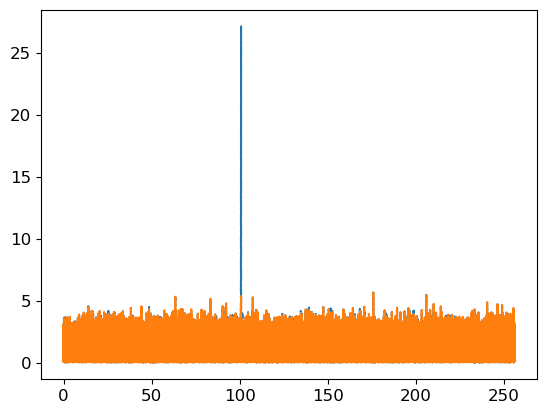

1


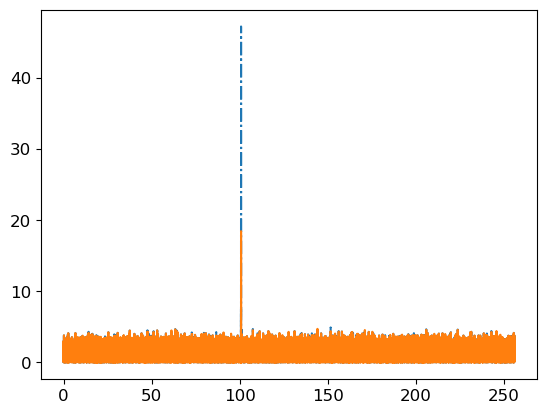

2


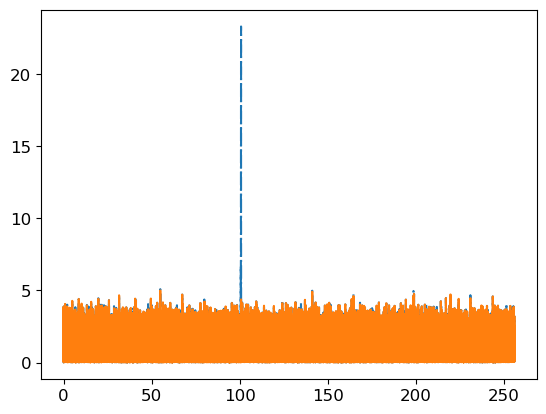

3


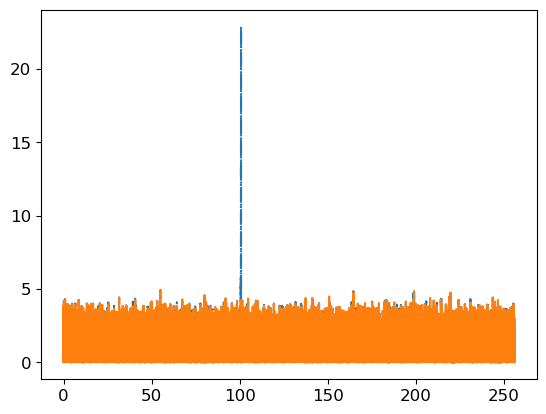

4


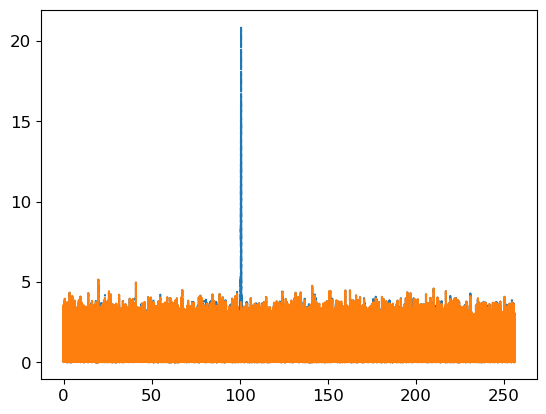

5


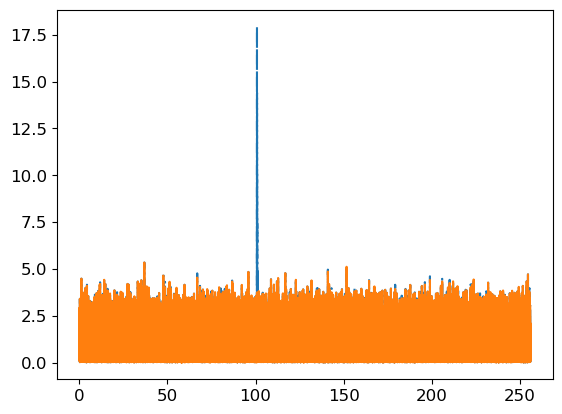

6


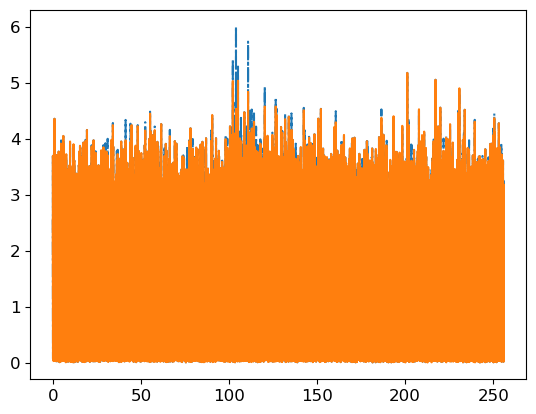

7


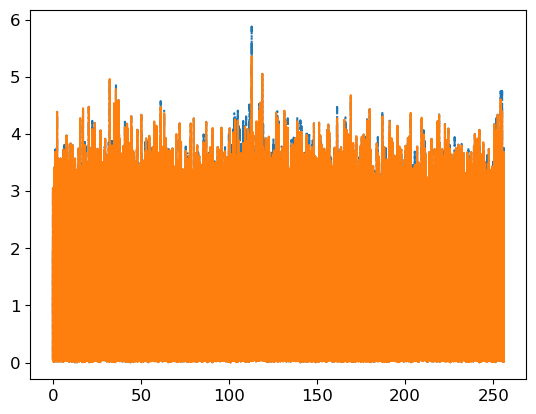

8


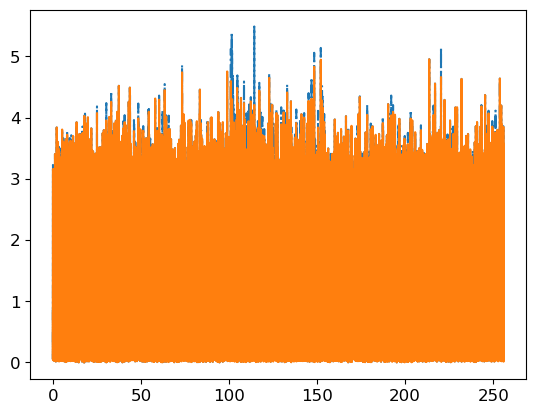

9


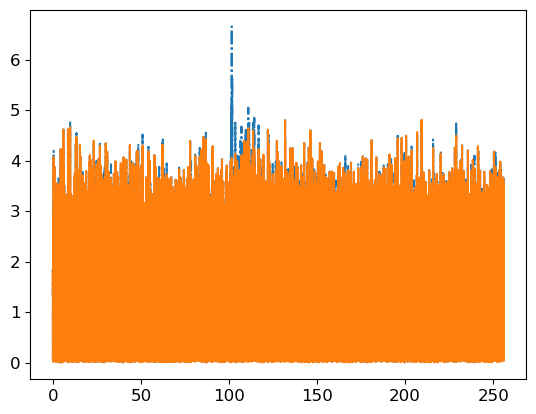

10


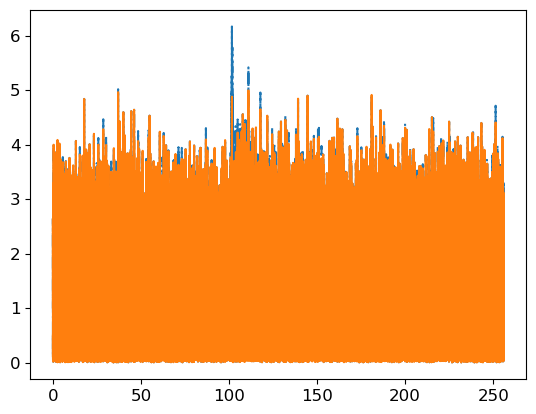

11


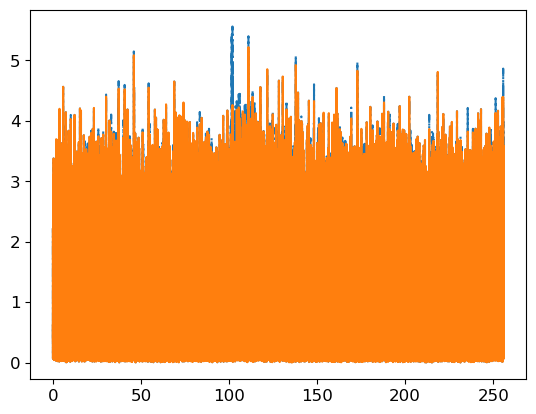

[25.3124840736438, 25.767297894745493, 175.848876953125, 27.120526624701785, 5.648714379045084, 32.29056479223794, 0, (22.40429821622306+15.283009711431268j)]
[19.66472776115617, 28.829538590310523, 100.79931640625, 47.24815104326686, 18.464040099215094, 8.245205185813742, 1, (-20.595228435655798-42.52322121724216j)]
[27.9260013682452, 28.42240443219461, 54.938232421875, 23.309569287151493, 4.996055285313835, 35.75489966726643, 2, (3.5156245403592954-23.04292525795585j)]
[27.191392084477236, 27.980437348212533, 54.938720703125, 22.910564839078155, 4.885162991534969, 36.389797973421565, 3, (10.897390097418072-20.152937014497386j)]
[26.58109028449369, 33.05341387654879, 19.76123046875, 20.911375573568254, 5.151322179319949, 38.91605885352805, 4, (-15.315306773033015-14.238223443488874j)]
[11.66828398486552, 35.14524881998979, 36.87939453125, 17.938113110906432, 5.338074663108397, 28.952635181060874, 5, (15.802760405221346+8.48814853515428j)]
[20.938949466673236, 30.580004573878607, 201.2

In [ ]:
for j in range(1):

    print("Recovery number:",j)
    print(' ')

    ts1 = timeseries.load_timeseries(f"Signals_BBH_BNS/Data_{j}.hdf")
    psd1 = psd_data(ts1)
    mass_1,mass_2,time,snrp,total,index_trigger,snrp_compl = recovery(ts1,12,data_templates,psd1)

    print(' ')

In [ ]:
 mass_1,mass_2,time,snrp,index_trigger,snrp_compl

(19.66472776115617,
 28.829538590310523,
 100.79931640625,
 18.464040099215094,
 1,
 (-20.595228435655798-42.52322121724216j))

In [ ]:
aligned_temp = aligned_template(mass_1, mass_2, time, snrp_compl, ts1, index_trigger)

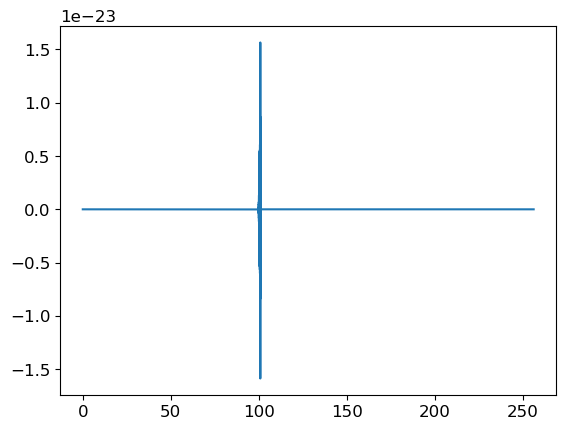

In [ ]:
aligned_temp.plot()

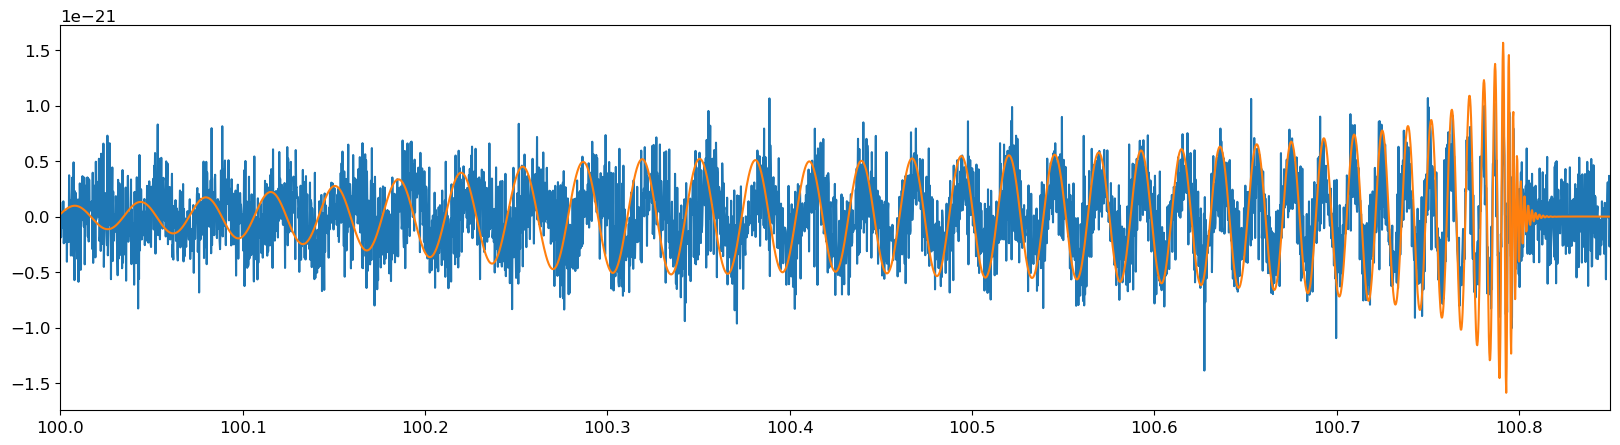

In [ ]:
pp.figure(figsize=(20,5))
pp.plot(ts1.sample_times,ts1)
pp.plot(ts1.sample_times,aligned_temp*100)
# pp.plot(aligned_temp.sample_times, aligned_temp)
pp.xlim(100.,100.85)
pp.show()

In [ ]:
index = index_trigger
i_new,snrp_signal,M1, M2, T, Complex_SNRP = find_signal(index, aligned_temp)
print(i_new,temp_bank[i_new],snrp_signal)

0 [25.3124840736438, 25.767297894745493] 5243.406634811634


In [ ]:
T_B1_MF = timeseries.load_timeseries(f"Signals_BBH_BNS/snr_complete_series/snr{index}.hdf")

(100.0, 100.85)

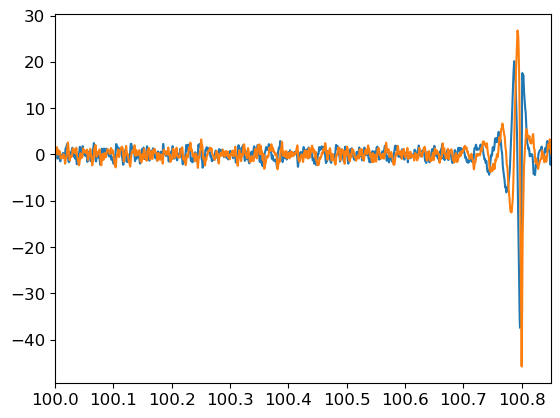

In [ ]:
T_B1_MF.plot()
pp.xlim(100.,100.85)

In [ ]:
i=0

cross = matched_filter(data_templates[i], aligned_temp,
                 psd=psd1, low_frequency_cutoff=30)
creal = cross.real()
cimag = cross.imag()

(100.6, 101.0)

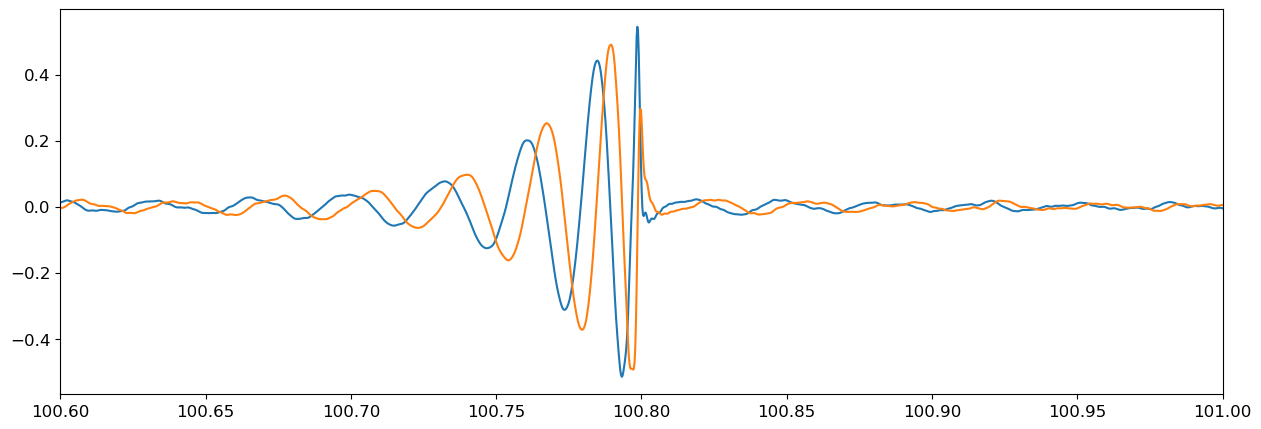

In [ ]:
pp.figure(figsize=(15,5))
creal.plot()
cimag.plot()
pp.xlim(100.6,101)

In [ ]:
cross1 = matched_filter(aligned_temp, data_templates[i],
                 psd=psd1, low_frequency_cutoff=30)
creal1 = cross1.real()
cimag1 = cross1.imag()

In [ ]:
creal2 = creal1
creal2.data = creal1.data[::-1]
creal2.start_time = creal.start_time

cimag2 = cimag1
cimag2.data = cimag1.data[::-1]
cimag2.start_time = cimag.start_time

(100.6, 101.0)

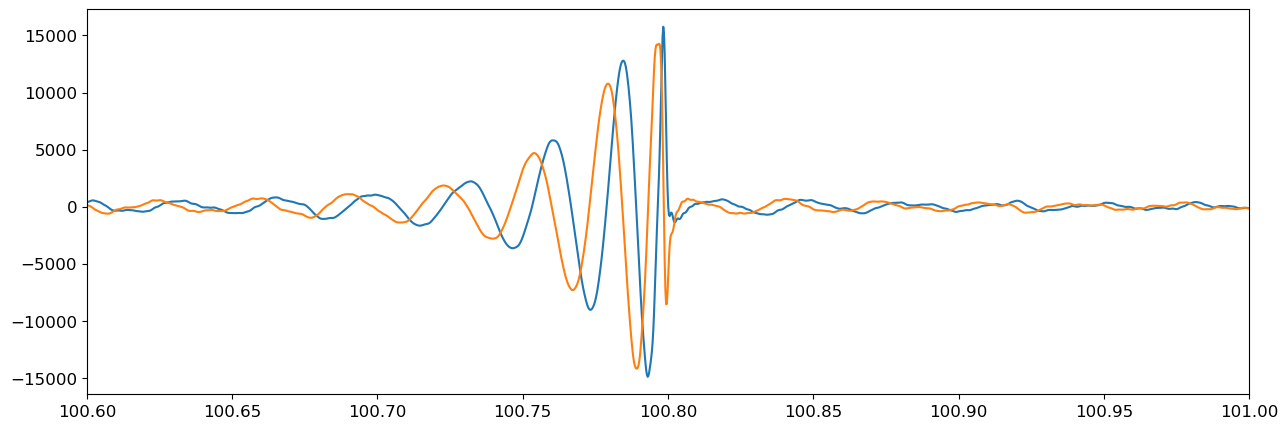

In [ ]:
pp.figure(figsize=(15,5))
creal2.plot()
cimag2.plot()

pp.xlim(100.6,101)